# Notebook 1: Model Components and Alternatives

## Learning Goals

- Understand ClimaOcean's architecture and component system
- Set up a realistic ocean simulation with appropriate numerics
- Add sea ice to create a three-component coupled system
- Integrate Python ocean models (Veros)
- Enable two-way coupling with a prognostic atmosphere (SpeedyWeather)

---

## Introduction to ClimaOcean

ClimaOcean is a **flexible Julia framework for coupling Earth system components**—not just an ocean package. It enables swappable components, prescribed or prognostic configurations, and cross-language integration with Python models.

The central abstraction is `OceanSeaIceModel`, which orchestrates component communication through flux exchanges.

---

## Architecture Overview

```
                    ATMOSPHERE
                    ──────────
                    │ Prescribed (JRA55, ERA5)
                    │ Prognostic (SpeedyWeather)
                    ▼
    ┌───────────────────────────────────────┐
    │         OceanSeaIceModel              │
    │    (Coupling & Flux Computation)      │
    └───────────────────────────────────────┘
                    │
        ┌───────────┴───────────┐
        ▼                       ▼
      OCEAN                   SEA ICE
    ──────────               ──────────
    │ Oceananigans           │ ClimaSeaIce
    │ SlabOcean              │ Prescribed
    │ Veros (Python)         │
```

**Key insight**: The interface is standardized. If you implement the right methods, your component plugs into the system.


## Setup

Let's load the necessary packages.

In [1]:
using Pkg
Pkg.activate("./")

using ClimaOcean
using Oceananigans
using Oceananigans.Units
using CairoMakie
using Printf
using Dates

  Activating project at `~/development/workshop`


---

## Part 1: Building an Ocean Model

Before coupling components, we need to set up an ocean model. We'll use a **tripolar grid** (avoiding the North Pole singularity) with realistic bathymetry.


In [3]:
arch = CPU()  # Use CPU for portability; switch to GPU() if available

# Grid dimensions
Nx, Ny, Nz = 120, 60, 15

# Vertical levels - stretched to resolve the surface better
z_faces = [-5200.0, -5150.0, -5080.0, -4980.0, -4840.0, -4650.0, 
           -4410.0, -4120.0, -3780.0, -3390.0, -2950.0, -2460.0, 
           -1920.0, -1330.0, -690.0, 0.0]

# Create the tripolar grid
underlying_grid = TripolarGrid(arch; size=(Nx, Ny, Nz), z=z_faces)

@info "Created tripolar grid: $(underlying_grid.Nx)×$(underlying_grid.Ny)×$(underlying_grid.Nz)"

[ Info: Created tripolar grid: 120×60×15


### Adding Realistic Bathymetry

We add bathymetry from ETOPO data using `regrid_bathymetry`. Key parameters:
- `minimum_depth=100`: Ensures all ocean points are at least 20m deep
- `major_basins=1`: Keeps only the main connected ocean basin


In [4]:
bottom_height = regrid_bathymetry(underlying_grid; minimum_depth=100, major_basins=1, interpolation_passes=20)
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom_height); active_cells_map=true)

[ Info: Interpolation passes of bathymetry size (21600, 10800, 1) onto a OrthogonalSphericalShellGrid target grid of size (120, 60, 15):
[ Info:     pass 1 to size (20526, 10263, 1)
[ Info:     pass 2 to size (19452, 9726, 1)
[ Info:     pass 3 to size (18378, 9189, 1)
[ Info:     pass 4 to size (17304, 8652, 1)
[ Info:     pass 5 to size (16230, 8115, 1)
[ Info:     pass 6 to size (15156, 7578, 1)
[ Info:     pass 7 to size (14082, 7041, 1)
[ Info:     pass 8 to size (13008, 6504, 1)
[ Info:     pass 9 to size (11934, 5967, 1)
[ Info:     pass 10 to size (10860, 5430, 1)
[ Info:     pass 11 to size (9786, 4893, 1)
[ Info:     pass 12 to size (8712, 4356, 1)
[ Info:     pass 13 to size (7638, 3819, 1)
[ Info:     pass 14 to size (6564, 3282, 1)
[ Info:     pass 15 to size (5490, 2745, 1)
[ Info:     pass 16 to size (4416, 2208, 1)
[ Info:     pass 17 to size (3342, 1671, 1)
[ Info:     pass 18 to size (2268, 1134, 1)
[ Info:     pass 19 to size (1194, 597, 1)
[ Info:     pass 20 to siz

120×60×15 ImmersedBoundaryGrid{Float64, Periodic, RightConnected, Bounded} on CPU with 4×4×4 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-2211.83, min(z)=-5200.0, max(z)=0.0)
├── underlying_grid: 120×60×15 OrthogonalSphericalShellGrid{Float64, Periodic, RightConnected, Bounded} on CPU with 4×4×4 halo
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.149 degrees       variably spaced with min(Δλ)=0.0686029, max(Δλ)=3.16048
├── latitude:  RightConnected  extent 172.833 degrees variably spaced with min(Δφ)=0.104351, max(Δφ)=2.88136
└── z:         Bounded  z ∈ [-5200.0, 0.0]            variably spaced with min(Δz)=50.0, max(Δz)=690.0

### Visualizing the Bathymetry


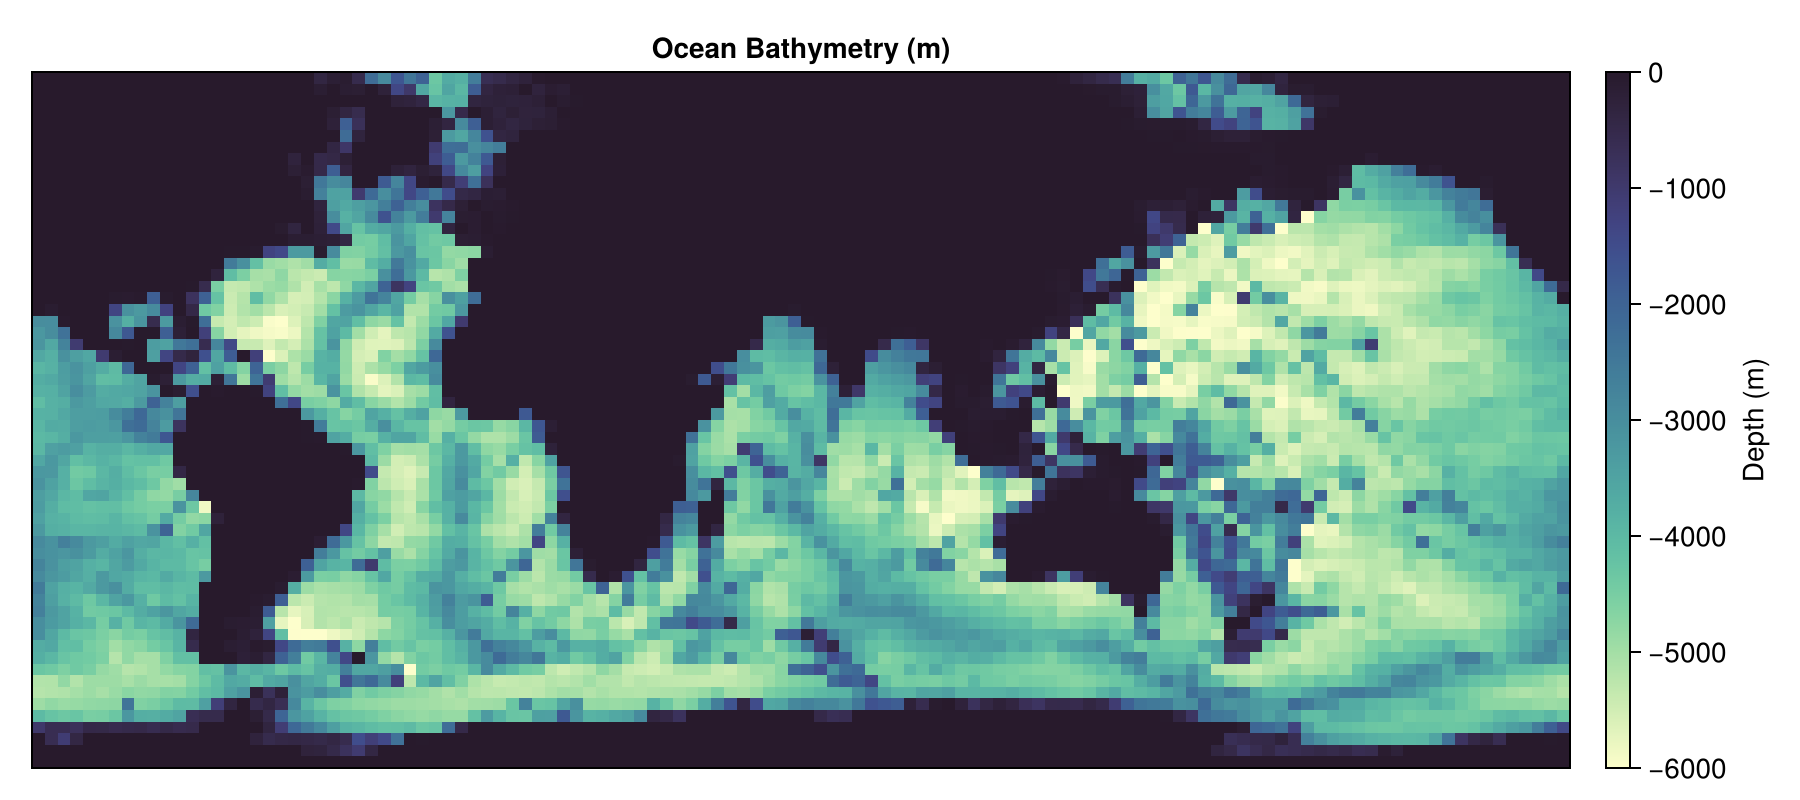

In [5]:
fig = Figure(size=(900, 400), fontsize=14)
ax = Axis(fig[1, 1], title="Ocean Bathymetry (m)")

bathy_data = interior(bottom_height, :, :, 1)
hm = heatmap!(ax, Array(bathy_data); colormap=:deep, colorrange=(-6000, 0), nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label="Depth (m)")
hidedecorations!(ax)

fig

### Ocean Configuration

**Closures** parameterize unresolved turbulent motions:
- **Vertical**: TKE-based scheme for wind-driven mixing
- **Horizontal**: Scale-aware biharmonic diffusivity ($\nu_h = A_z^2/\lambda$)

**Advection schemes**:
- Tracers: Centered scheme (needs diffusion for stability)
- Momentum: VectorInvariant (preserves energy and enstrophy)


In [6]:
# Scale-aware horizontal biharmonic diffusivity
@inline νhb(i, j, k, grid, ℓx, ℓy, ℓz, clock, fields, λ) = 
    Oceananigans.Operators.Az(i, j, k, grid, ℓx, ℓy, ℓz)^2 / λ

# Closures
vertical_closure = ClimaOcean.Oceans.default_ocean_closure()
horizontal_closure = HorizontalScalarBiharmonicDiffusivity(ν=νhb, κ=νhb, 
                                                           discrete_form=true, 
                                                           parameters=40days)

tracer_advection = Centered()
momentum_advection = VectorInvariant()

VectorInvariant
├── vorticity_scheme: Oceananigans.Advection.EnstrophyConserving{Float64}
└── vertical_advection_scheme: Oceananigans.Advection.EnergyConserving{Float64}

### Creating the Ocean Simulation

The `ocean_simulation` constructor sets up a `HydrostaticFreeSurfaceModel` with sensible defaults for realistic ocean modeling.


In [7]:
ocean = ocean_simulation(grid; 
                         closure = (vertical_closure, horizontal_closure), 
                         tracer_advection, 
                         momentum_advection,
                         materialize_buoyancy_gradients = true) # Just some perfomance optimization flag

@info "Ocean simulation created!"

┌ Warning: Split barotropic-baroclinic time stepping with SplitRungeKutta3TimeStepper is experimental.
│ Use at own risk, and report any issues encountered at https://github.com/CliMA/Oceananigans.jl/issues.
└ @ Oceananigans.TimeSteppers ~/.julia/packages/Oceananigans/HDYmM/src/TimeSteppers/split_hydrostatic_runge_kutta_3.jl:59
[ Info: Ocean simulation created!


### Initialize from ECCO4 Climatology

We initialize temperature and salinity from the **ECCO4 Monthly** climatology—a state-of-the-art ocean reanalysis product combining observations with numerical models.

In [ ]:
ENV["ECCO_USERNAME"] = "xxxxx"
ENV["ECCO_WEBDAV_PASSWORD"] = "xxxx"

set!(ocean.model, T=ECCOMetadatum(:temperature),
                  S=ECCOMetadatum(:salinity))

T = ocean.model.tracers.T
S = ocean.model.tracers.S

@info "Initial temperature range: $(extrema(T))"
@info "Initial salinity range: $(extrema(S))"

[ Info: Initial temperature range: (-1.6227575540542603, 18.71958351135254)
[ Info: Initial salinity range: (33.53400802612305, 38.62847900390625)


### Visualizing Initial Conditions


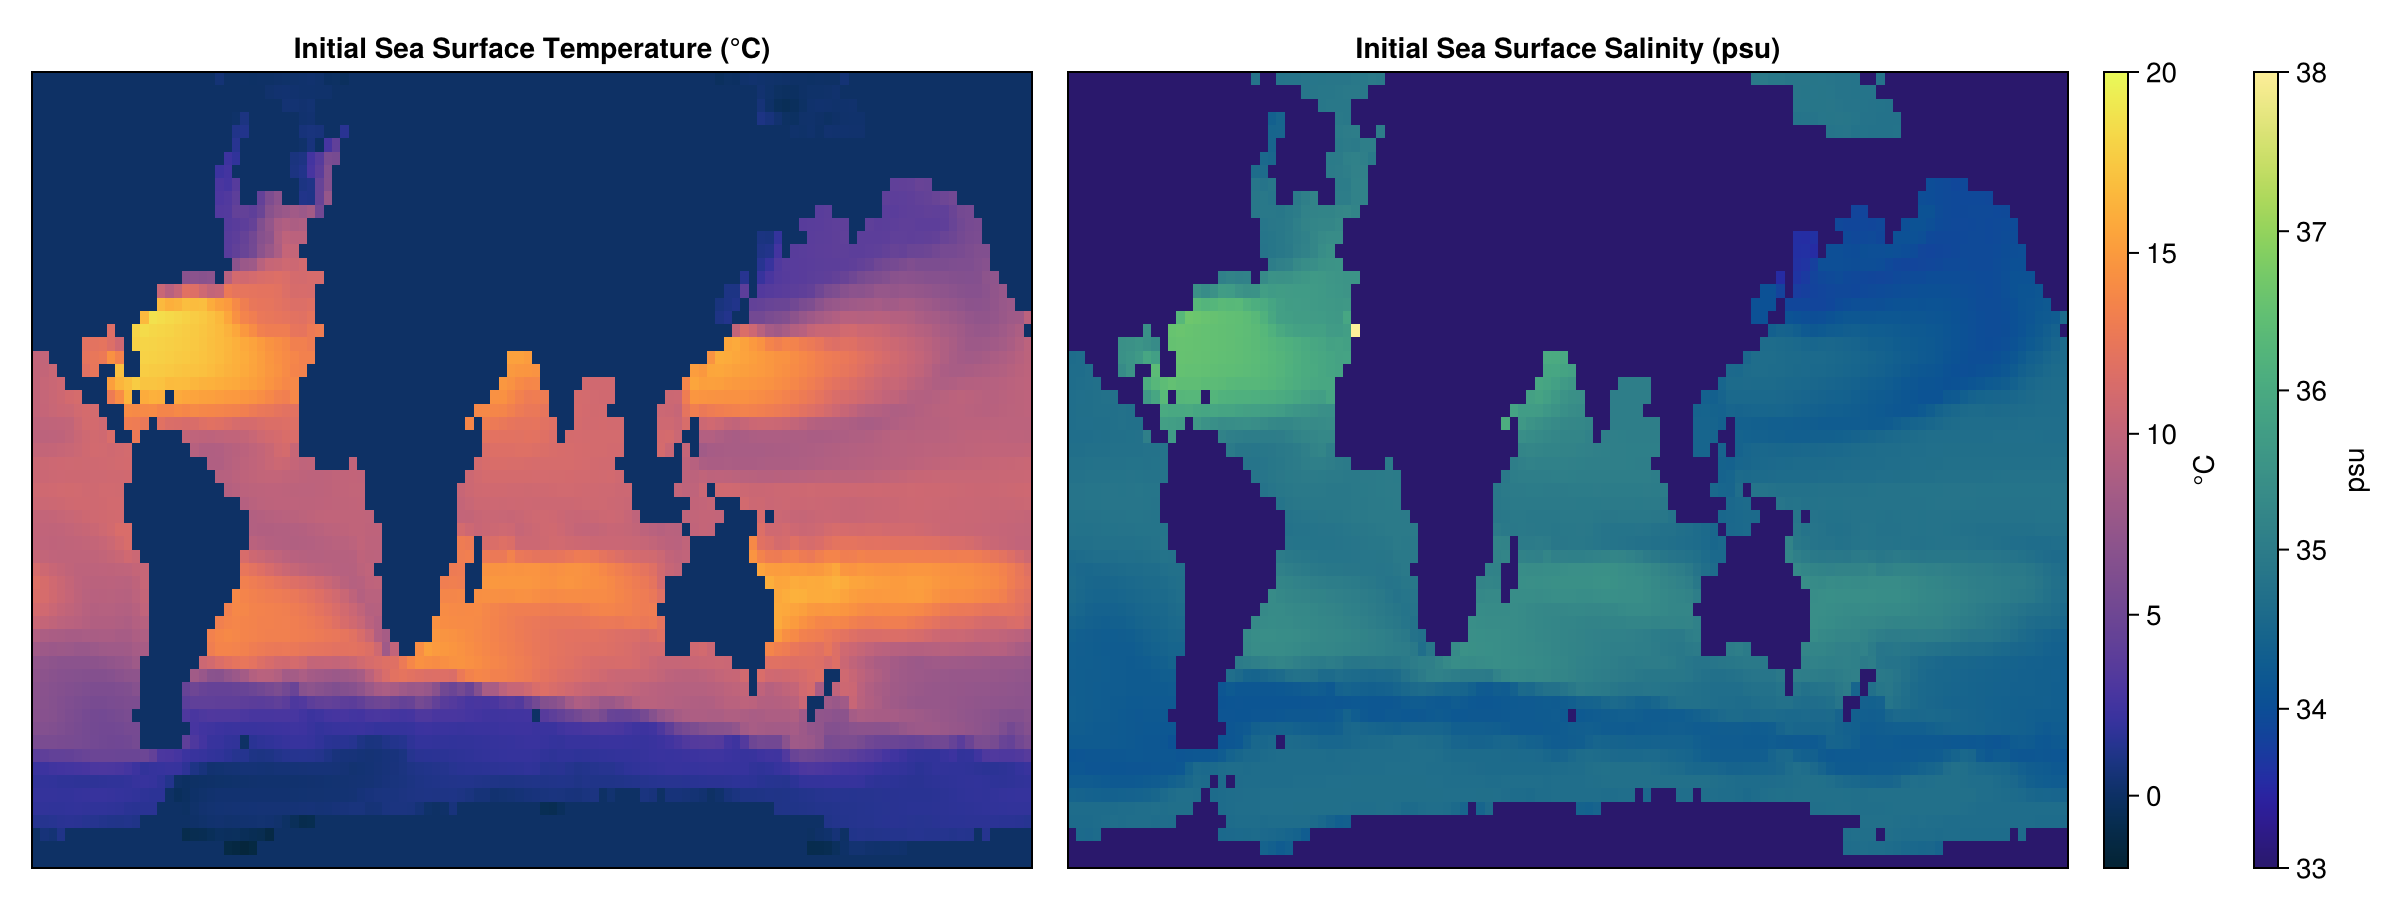

In [9]:
# Extract surface fields
SST_initial = Array(interior(T, :, :, grid.Nz))
SSS_initial = Array(interior(S, :, :, grid.Nz))

fig = Figure(size=(1200, 450), fontsize=14)

ax1 = Axis(fig[1, 1], title="Initial Sea Surface Temperature (°C)")
ax2 = Axis(fig[1, 2], title="Initial Sea Surface Salinity (psu)")

hm1 = heatmap!(ax1, SST_initial; colormap=:thermal, colorrange=(-2, 20), nan_color=:lightgray)
hm2 = heatmap!(ax2, SSS_initial; colormap=:haline,  colorrange=(33, 38), nan_color=:lightgray)

Colorbar(fig[1, 3], hm1, label="°C")
Colorbar(fig[1, 4], hm2, label="psu")

hidedecorations!(ax1)
hidedecorations!(ax2)

fig

### Load the Prescribed Atmosphere (JRA55)

**JRA55** provides near-surface winds, air temperature, humidity, precipitation, and radiation. As a prescribed atmosphere, it forces the ocean (one-way coupling: atmosphere → ocean).


In [10]:
atmosphere = JRA55PrescribedAtmosphere(arch; backend=JRA55NetCDFBackend(10))

@info "Atmosphere loaded with grid: $(atmosphere.grid)"

┌ Info: Atmosphere loaded with grid: 640×320×1 LatitudeLongitudeGrid{Float32, Periodic, Bounded, Flat} on CPU with 3×3×0 halo
│ ├── longitude: Periodic λ ∈ [-0.28125, 359.719) variably spaced with min(Δλ)=0.5625, max(Δλ)=0.5625
│ ├── latitude:  Bounded  φ ∈ [-90.0, 90.0]       variably spaced with min(Δφ)=0.558556, max(Δφ)=0.708366
└ └── z:         Flat z                           


### Couple Ocean and Atmosphere (One-way)

`OceanSeaIceModel` orchestrates flux computation (heat, freshwater, momentum), radiation, and component synchronization. In this Oceananigans setup, all flux computations happen on the ocean's horizontal grid.


In [11]:
coupled_model = OceanSeaIceModel(ocean; atmosphere)

@info "Coupled model created!"

[ Info: Coupled model created!


### Visualizing Air-Sea Fluxes

Initial air-sea fluxes computed using similarity theory: sensible heat, latent heat, and momentum (wind stress).


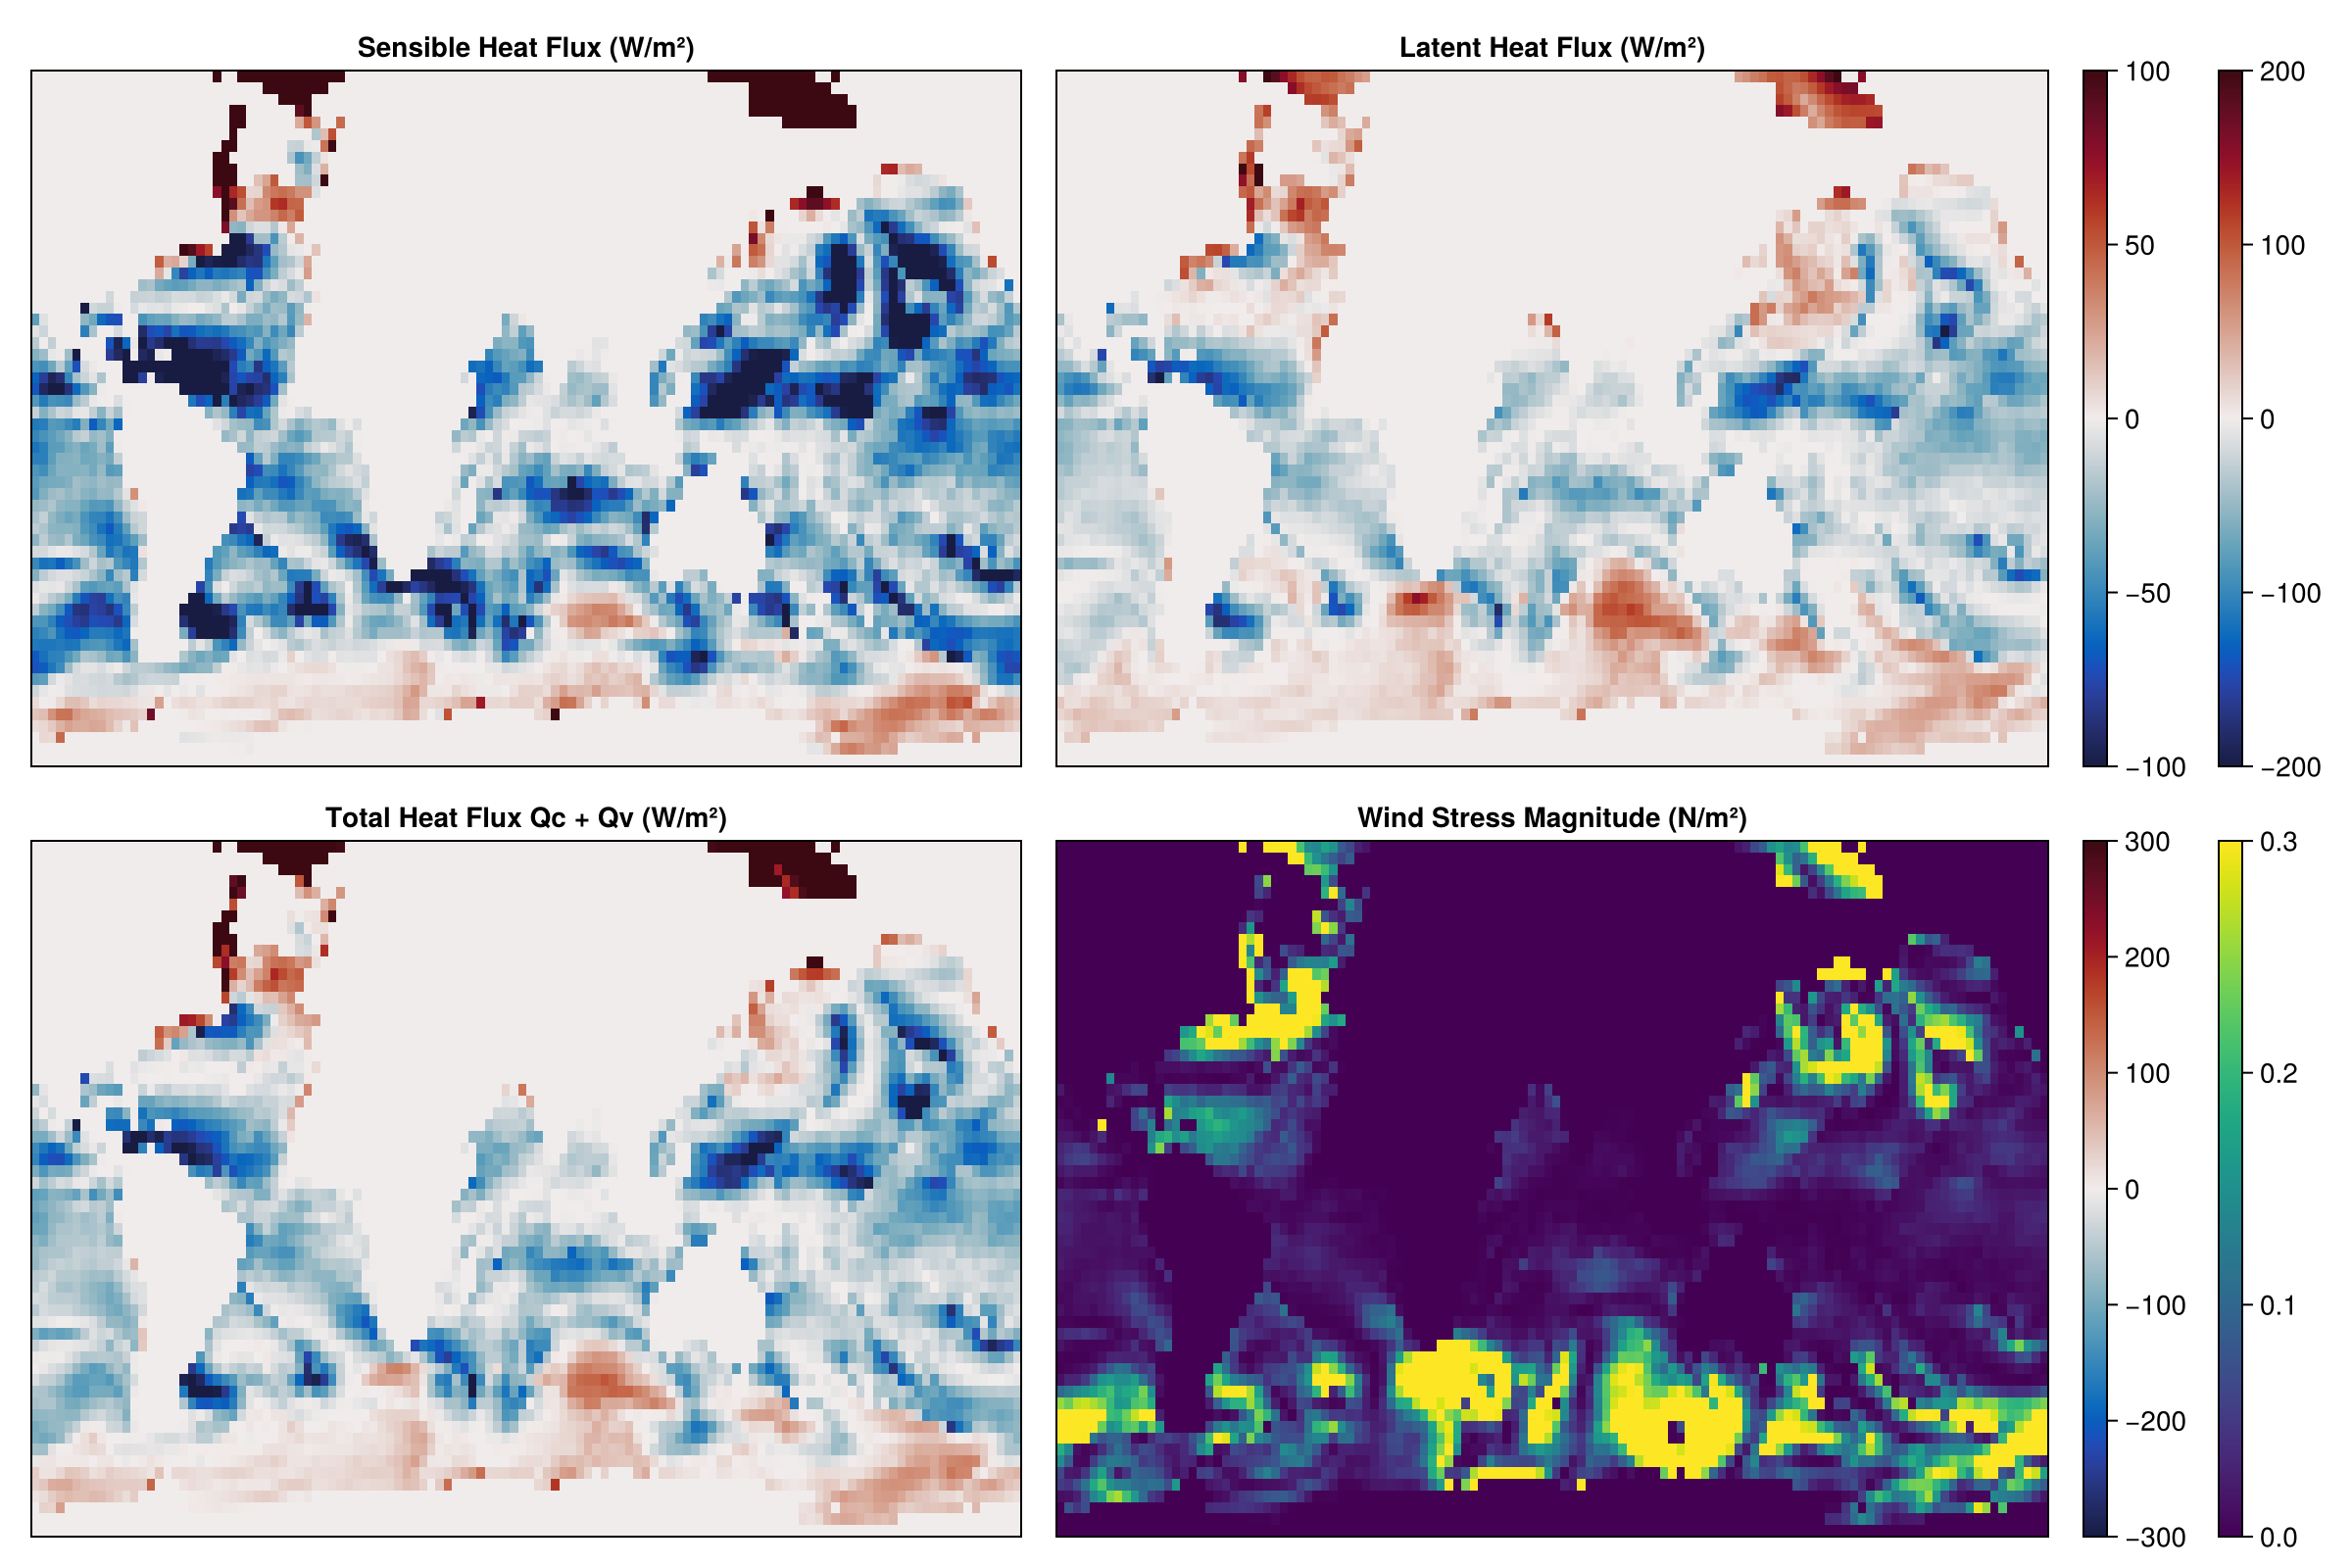

In [12]:
# Access the air-sea fluxes from the coupled model
ao_fluxes = coupled_model.interfaces.atmosphere_ocean_interface.fluxes

# Extract flux fields
Qc = interior(ao_fluxes.sensible_heat, :, :, 1)   # Sensible heat (W/m²)
Qv = interior(ao_fluxes.latent_heat, :, :, 1)     # Latent heat (W/m²)
τx = interior(ao_fluxes.x_momentum, :, :, 1)      # Zonal wind stress (N/m²)
τy = interior(ao_fluxes.y_momentum, :, :, 1)      # Meridional wind stress (N/m²)

# Compute wind stress magnitude
τ_mag = @. sqrt(τx^2 + τy^2)

fig = Figure(size=(1200, 800), fontsize=14)

ax1 = Axis(fig[1, 1], title="Sensible Heat Flux (W/m²)")
ax2 = Axis(fig[1, 2], title="Latent Heat Flux (W/m²)")
ax3 = Axis(fig[2, 1], title="Total Heat Flux Qc + Qv (W/m²)")
ax4 = Axis(fig[2, 2], title="Wind Stress Magnitude (N/m²)")

hm1 = heatmap!(ax1, Qc; colormap=:balance, colorrange=(-100, 100), nan_color=:lightgray)
hm2 = heatmap!(ax2, Qv; colormap=:balance, colorrange=(-200, 200), nan_color=:lightgray)
hm3 = heatmap!(ax3, Qc .+ Qv; colormap=:balance, colorrange=(-300, 300), nan_color=:lightgray)
hm4 = heatmap!(ax4, τ_mag; colormap=:viridis, colorrange=(0, 0.3), nan_color=:lightgray)

Colorbar(fig[1, 3], hm1)
Colorbar(fig[1, 4], hm2)
Colorbar(fig[2, 3], hm3)
Colorbar(fig[2, 4], hm4)

for ax in [ax1, ax2, ax3, ax4]
    hidedecorations!(ax)
end

fig

---

## Part 2: Adding Sea Ice

Sea ice is crucial for insulating the ocean from cold polar air, reflecting solar radiation (high albedo), and modifying air-sea flux partitioning.


### Create a Sea Ice Simulations from the Ocean component

We create sea ice using `sea_ice_simulation`, which tracks ice thickness (`h`) and concentration (`ℵ`). Setting `dynamics=nothing` disables ice motion (thermodynamics only). Both components are initialized from ECCO4 Monthly climatology.


In [13]:
# Create sea ice simulation - this is the new component!
sea_ice = sea_ice_simulation(grid, ocean; dynamics=nothing)

# Initialize sea ice from ECCO, follow the README.md in 
# https://github.com/CliMA/ClimaOcean.jl/blob/main/src/DataWrangling/ECCO/README.md
set!(sea_ice.model, h=Metadatum(:sea_ice_thickness, dataset=ECCO4Monthly()),
                    ℵ=Metadatum(:sea_ice_concentration, dataset=ECCO4Monthly()))

@info "Ocean and sea ice simulations created!"

[ Info: Ocean and sea ice simulations created!


### Visualize Initial Sea Ice Conditions

Initial sea ice state from ECCO climatology: thickness (1-3m in polar regions) and concentration (0 = open water, 1 = fully ice-covered).


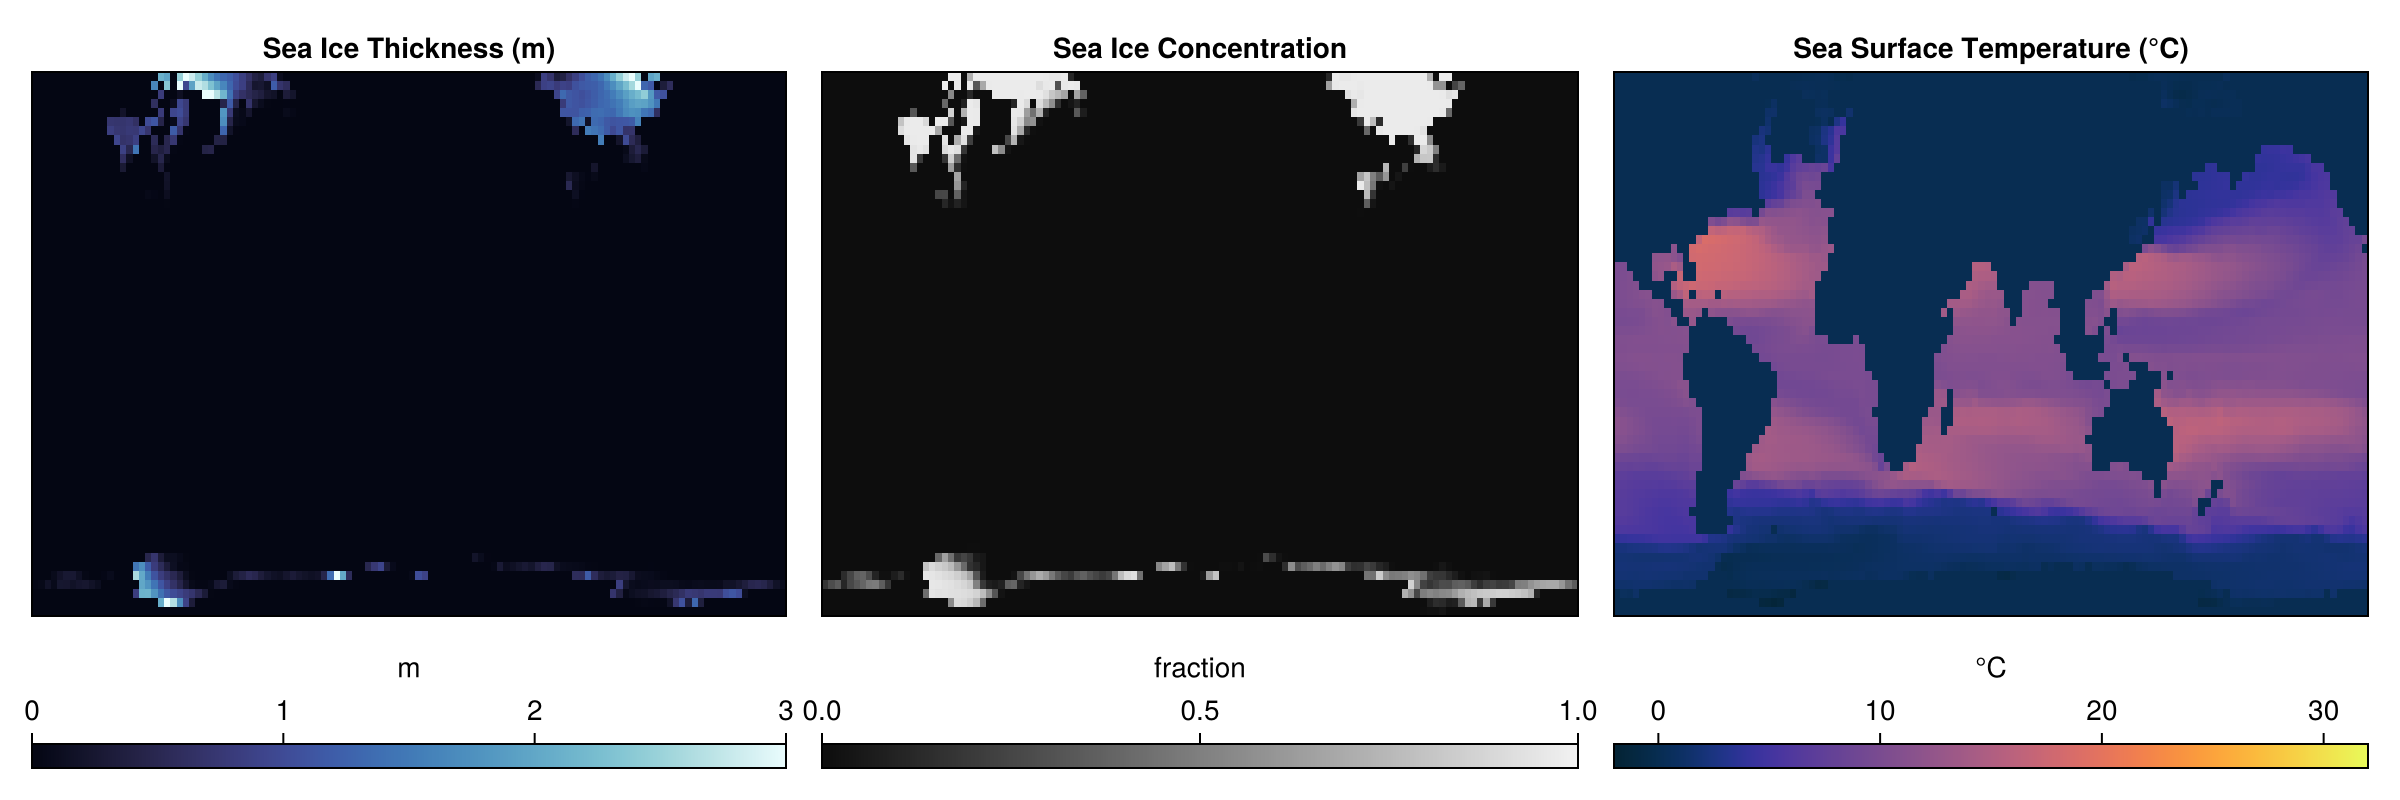

In [14]:
# Extract sea ice fields
h = sea_ice.model.ice_thickness  
ℵ = sea_ice.model.ice_concentration
T = ocean.model.tracers.T

h_initial = Array(interior(h, :, :, 1))
ℵ_initial = Array(interior(ℵ, :, :, 1))
SST_initial = Array(interior(T, :, :, grid.Nz))

fig = Figure(size=(1200, 400), fontsize=14)

ax1 = Axis(fig[1, 1], title="Sea Ice Thickness (m)")
ax2 = Axis(fig[1, 2], title="Sea Ice Concentration")
ax3 = Axis(fig[1, 3], title="Sea Surface Temperature (°C)")

hm1 = heatmap!(ax1, h_initial;   colormap=:ice, colorrange=(0, 3), nan_color=:lightgray)
hm2 = heatmap!(ax2, ℵ_initial;   colormap=:grays, colorrange=(0, 1), nan_color=:lightgray)
hm3 = heatmap!(ax3, SST_initial; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)

Colorbar(fig[2, 1], hm1, label="m", vertical=false)
Colorbar(fig[2, 2], hm2, label="fraction", vertical=false)
Colorbar(fig[2, 3], hm3, label="°C", vertical=false)

for ax in [ax1, ax2, ax3]
    hidedecorations!(ax)
end

fig

### Couple Ocean, Sea Ice, and (Prescribed!) Atmosphere

The three-component coupling automatically partitions fluxes between ice-covered and open-ocean regions, with three interfaces: atmosphere-ocean, atmosphere-sea ice, and sea ice-ocean.


In [15]:
# Create the THREE?-component coupled model
coupled_model = OceanSeaIceModel(ocean, sea_ice; atmosphere)

@info "Two-component coupled model created: Ocean + Sea Ice + Atmosphere!"

[ Info: Two-component coupled model created: Ocean + Sea Ice + Atmosphere!


### Visualize Interface Fluxes

Fluxes at the three interfaces: atmosphere-ocean, atmosphere-sea ice, and sea ice-ocean (melting/freezing).


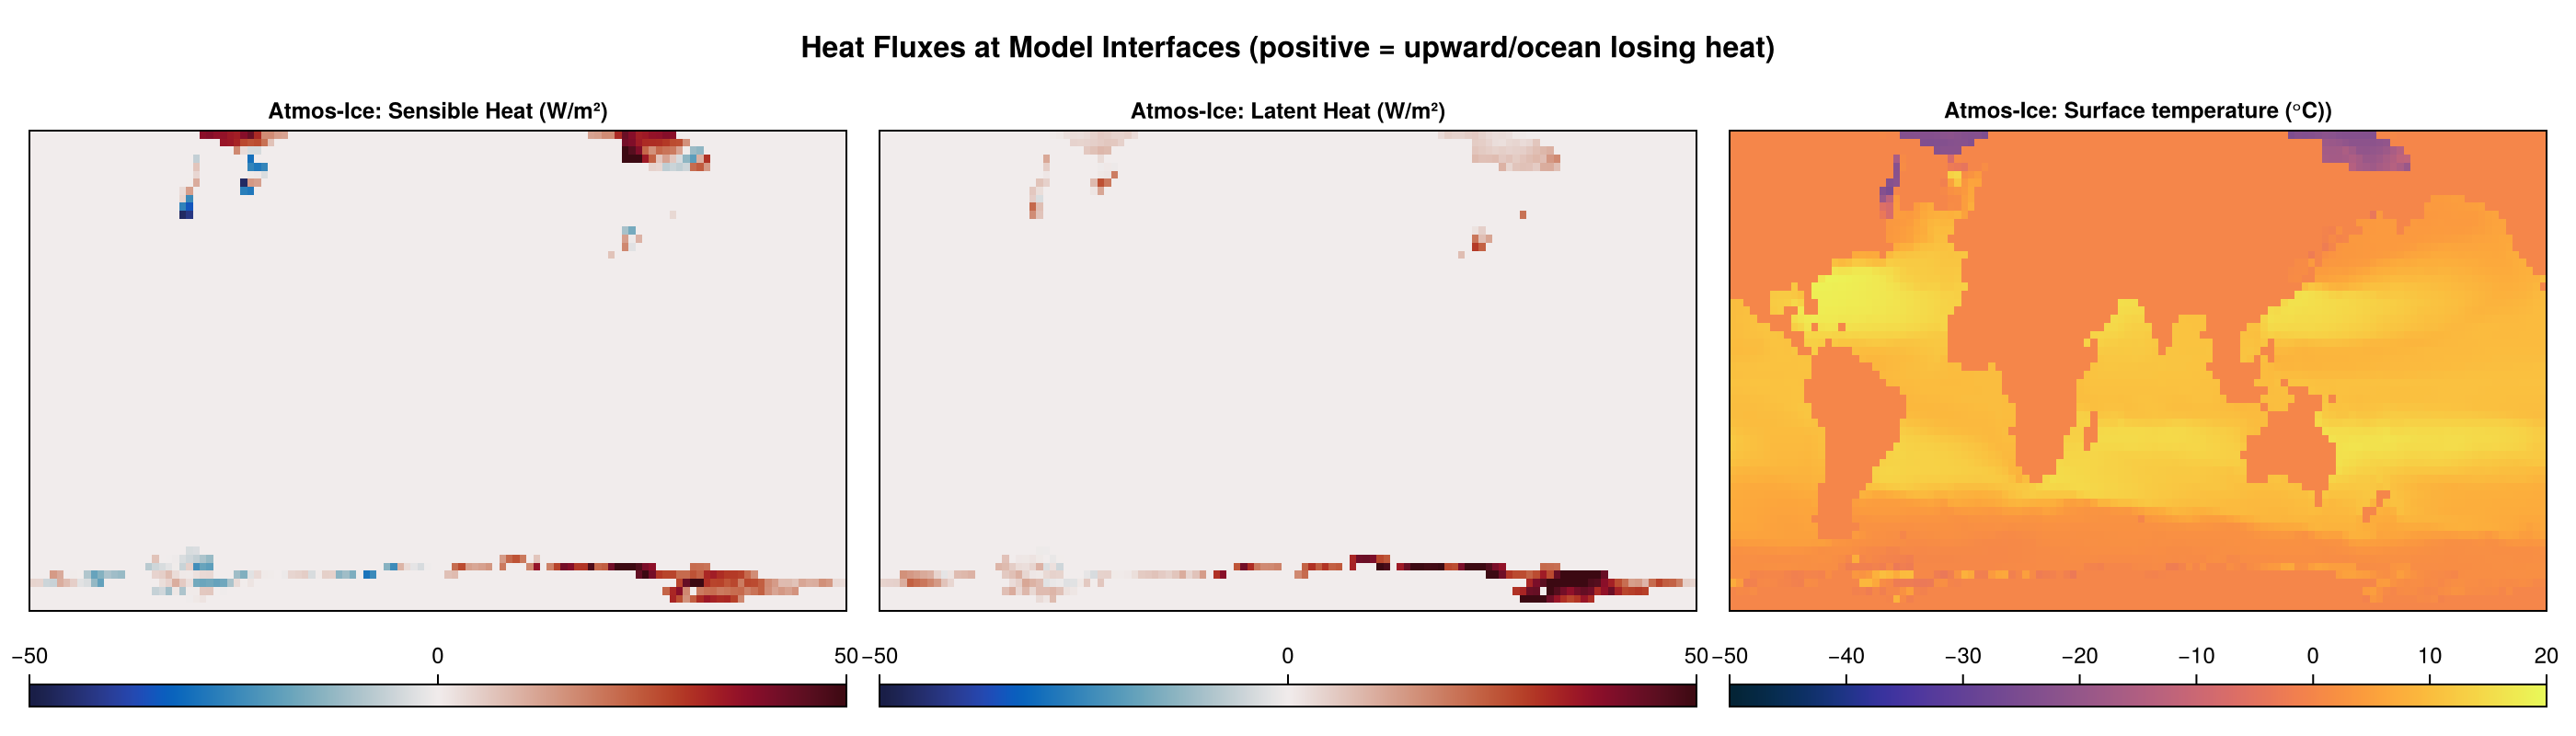

In [16]:
# Access the interface fluxes
ai_fluxes = coupled_model.interfaces.atmosphere_sea_ice_interface.fluxes       # Atmosphere-Sea Ice
ai_temp   = coupled_model.interfaces.atmosphere_sea_ice_interface.temperature  # Atmosphere-Sea Ice temperature

# Extract heat fluxes (W/m²) and temperature
Qc_ai = interior(ai_fluxes.sensible_heat, :, :, 1)  # Sensible heat atmos-ice
Qv_ai = interior(ai_fluxes.latent_heat, :, :, 1)    # Latent heat atmos-ice
T_ai  = interior(ai_temp, :, :, 1)   # Heat flux ice-ocean

fig = Figure(size=(1400, 400), fontsize=12)

ax1 = Axis(fig[1, 1], title="Atmos-Ice: Sensible Heat (W/m²)")
ax2 = Axis(fig[1, 2], title="Atmos-Ice: Latent Heat (W/m²)")
ax3 = Axis(fig[1, 3], title="Atmos-Ice: Surface temperature (ᵒC))")
hm1 = heatmap!(ax1, Qc_ai; colormap=:balance, colorrange=(-50, 50), nan_color=:lightgray)
hm2 = heatmap!(ax2, Qv_ai; colormap=:balance, colorrange=(-50, 50), nan_color=:lightgray)
hm3 = heatmap!(ax3,  T_ai; colormap=:thermal, colorrange=(-50, 20), nan_color=:lightgray)

# Add colorbars
Colorbar(fig[2, 1], hm1; vertical=false)
Colorbar(fig[2, 2], hm2; vertical=false)
Colorbar(fig[2, 3], hm3; vertical=false)

for ax in [ax1, ax2, ax3]
    hidedecorations!(ax)
end

Label(fig[0, 1:3], "Heat Fluxes at Model Interfaces (positive = upward/ocean losing heat)", 
      fontsize=16, font=:bold)

fig

### Run the Simulation

We run for **10 days**, saving sea ice and SST fields daily.


In [17]:
simulation = Simulation(coupled_model; Δt=1hours, stop_time=10days)

# Set up output writer for sea ice and SST
h_ice = sea_ice.model.ice_thickness     # Ice thickness
ℵ_ice = sea_ice.model.ice_concentration # Ice concentration
T_ocean = ocean.model.tracers.T

SST = Field(T_ocean; indices=(:, :, grid.Nz))  # Surface temperature slice

simulation.output_writers[:fields] = JLD2Writer(ocean.model, (; SST, h=h_ice, ℵ=ℵ_ice);
                                                schedule = TimeInterval(1days),
                                                filename = "sea_ice_output.jld2",
                                                overwrite_existing = true)

# Progress callback
wall_time = Ref(time_ns())

function progress(sim)
    step_time = 1e-9 * (time_ns() - wall_time[])
    @info @sprintf("Time: %s | Wall: %s", prettytime(sim), prettytime(step_time))
    wall_time[] = time_ns()
    return nothing
end

add_callback!(simulation, progress, IterationInterval(50))

@info "Running ocean + sea ice + atmosphere simulation..."
run!(simulation)

[ Info: Running ocean + sea ice + atmosphere simulation...
[ Info: Initializing simulation...
[ Info: Time: 0 seconds | Wall: 7.704 seconds
[ Info:     ... simulation initialization complete (7.264 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (2.939 minutes).
[ Info: Time: 2.083 days | Wall: 3.663 minutes
[ Info: Time: 4.167 days | Wall: 14.755 seconds
[ Info: Time: 6.250 days | Wall: 14.706 seconds
[ Info: Time: 8.333 days | Wall: 14.665 seconds
[ Info: Simulation is stopping after running for 4.595 minutes.
[ Info: Simulation time 10 days equals or exceeds stop time 10 days.


### Visualize Results: Sea Ice Evolution


[ Info: Loaded 11 snapshots from t=0 seconds to t=10 days


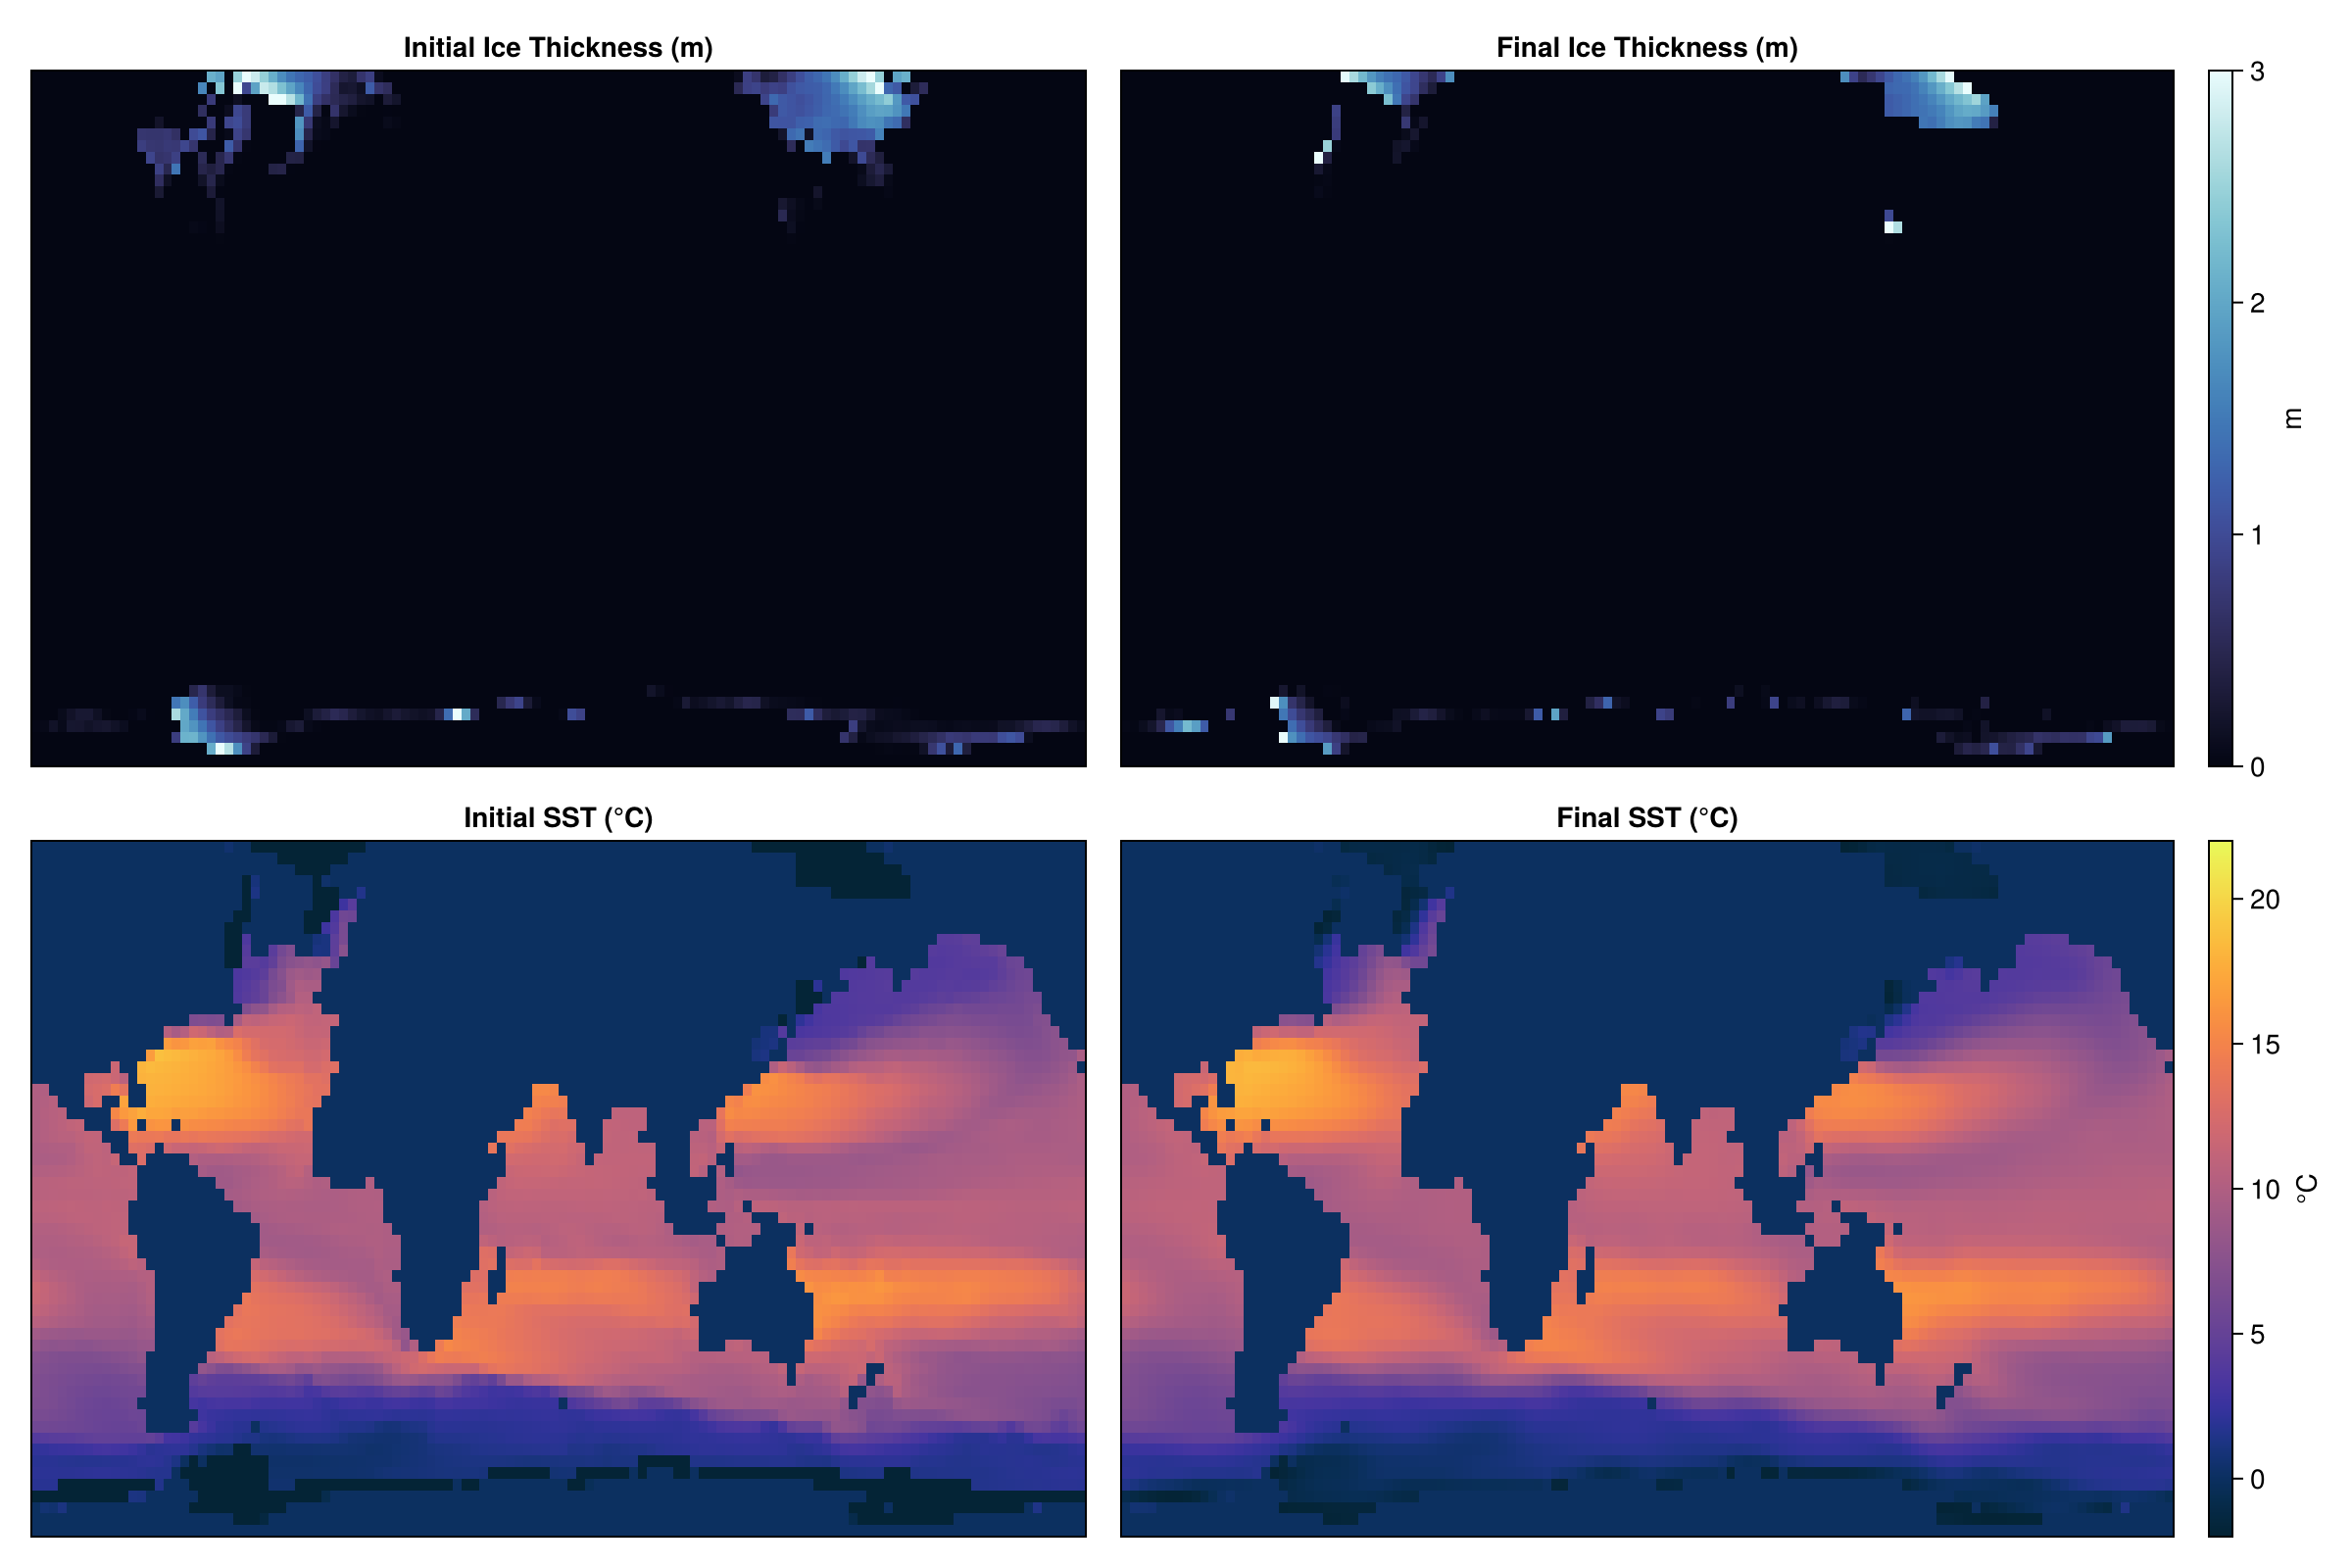

In [19]:
# Load saved output using FieldTimeSeries
SST_ts = FieldTimeSeries("sea_ice_output.jld2", "SST")
h_ts   = FieldTimeSeries("sea_ice_output.jld2", "h")
times  = SST_ts.times

@info "Loaded $(length(times)) snapshots from t=$(prettytime(times[1])) to t=$(prettytime(times[end]))"

# Get initial and final states
SST_first = Array(interior(SST_ts[1], :, :, 1))
SST_last = Array(interior(SST_ts[end], :, :, 1))
h_first = Array(interior(h_ts[1], :, :, 1))
h_last = Array(interior(h_ts[end], :, :, 1))

fig = Figure(size=(1200, 800), fontsize=14)

ax1 = Axis(fig[1, 1], title="Initial Ice Thickness (m)")
ax2 = Axis(fig[1, 2], title="Final Ice Thickness (m)")
ax3 = Axis(fig[2, 1], title="Initial SST (°C)")
ax4 = Axis(fig[2, 2], title="Final SST (°C)")

hm1 = heatmap!(ax1, h_first;   colormap=:ice,     colorrange=(0, 3),   nan_color=:lightgray)
hm2 = heatmap!(ax2, h_last;    colormap=:ice,     colorrange=(0, 3),   nan_color=:lightgray)
hm3 = heatmap!(ax3, SST_first; colormap=:thermal, colorrange=(-2, 22), nan_color=:lightgray)
hm4 = heatmap!(ax4, SST_last;  colormap=:thermal, colorrange=(-2, 22), nan_color=:lightgray)

Colorbar(fig[1, 3], hm1, label="m")
Colorbar(fig[2, 3], hm3, label="°C")

for ax in [ax1, ax2, ax3, ax4]
    hidedecorations!(ax)
end

fig

### Animated Evolution of Sea Ice and SST

Watch ice melting/growth and SST changes, especially near ice edges where ice-ocean interactions are strongest.


In [36]:
n = Observable(1)

# Create animation using FieldTimeSeries
fig = Figure(size=(1000, 400), fontsize=14)
title_text = @lift "t = $(prettytime(times[$n]))"
ax1 = Axis(fig[1, 1]; title = @lift "Ice Thickness at " * $title_text)
ax2 = Axis(fig[1, 2]; title = @lift "SST at " * $title_text)
hidedecorations!(ax1)
hidedecorations!(ax2)

# Create observables for animation
h_frame = @lift interior(h_ts[$n], :, :, 1)
SST_frame = @lift interior(SST_ts[$n], :, :, 1)

hm1 = heatmap!(ax1, h_frame; colormap=:ice, colorrange=(0, 3), nan_color=:lightgray)
hm2 = heatmap!(ax2, SST_frame; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)

Colorbar(fig[1, 3], hm1, label="m")
Colorbar(fig[1, 4], hm2, label="°C")

# Record animation
record(fig, "sea_ice_evolution.mp4", 1:length(times); framerate=2) do i
    n[] = i
end

@info "Animation saved to sea_ice_evolution.mp4"

[ Info: Animation saved to sea_ice_evolution.mp4


In [37]:
# Display the video inline
using Base64
mp4_data = base64encode(read("sea_ice_evolution.mp4"))
display("text/html", """<video controls autoplay loop><source src="data:video/mp4;base64,$mp4_data" type="video/mp4"></video>""")

<source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAB+3VtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MiBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA1ANliIQAFP/+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAAMAAAMAACPwlWxzIMa2aeEgAAADAAADAAa6ef/5CCf/MAGigIStse3kvoHFzDiAW9ceh6oU763TKLEVstqbggudugrKjrqr1XSRPSrMvkZQYuFPfgjyoQkJJgldWwn3yo+766LqFQ3g+a1k5VQ4kpJJ2CC8frSd8sDMg6az37A/+YbW6/y9j82vzW2d5BThRaB4+shlnVzkH91T1PMPP7toEuTPoINy6zjaVZpj/dFFv0I8PX+oen7mU/+O8axevNfqi/Hc8x5CSkubtCWbhiGp4oRoycIT53lohNLzROtQQQe5h4jxuxK/WSgANexhtYfEx5VSzwABvVrkoFVRuY48oeoa+SoLiQnKnjRM4kzWctPdQGhKj2nzV4GbVMn2/HdVWuTE31I3g+zgNW1TFYRKYkKnLBEvyHICcvsGRKsY4+TWnVbmVvmvPqPgN0BY/QGYxyuC8ZOGY+1LGCj/yvyISS23GZV3EgfCxmDwiBf6XMVFvg9JGdjprN/+AYvVO3jm+zAI+Q/T/9hUjLIk+Lx4aafhBCj5GAdZG+jhX9CPChQQCbTF1xdG8RPR8V4XnQXqd3bJYxrcd3KRZQ7ZOAdiehTT/H3zWImW+92dw9/wrRd7cUbsPUDE7lJWgOWlm6xRQlHGM+UjDWScNnvGwp90CjdT25aGKfB68oul8oNgXnYtpQ7/+x5Q0PTssGNMFbQrYWAyI/to7Lk8At3lQsVwZr4XU0m7000XyX/MxwDZP1C0Q62pECkmEWafrfHdnsDlbPa0WnjjdlcfMzTTY/L5JXxxDpvcW0hm/BWdNiNruGyuf5W9ezYFvZ01XSpadlvwb5UgODSoe1KIHay1p7Yl5pQ3Wc/bPUXKBqL/89F3gkREgxuTlwg4jRpGUzdZclhhsnDg0aDa6p+URgwaf0rZGDenHrZvnzLvYF33UuSZEeDydI02gD0ESbjEq1YcEEWJPWsZEmM0wOEjbX2o4Krkd1mKKc148w9sEyOIrQNGwynlJ00KtNGvft8tdNmvOdMJ8ObrhgNbVOxiccKjrbdByrnSM7bT+bPXPoXji+ST4LwCLNssefJGsWOs7WhfS6yEHrEbmta3rA55PUBASc4Nlg9HcAGzNO5i0PzxJaz1oyIwXGfglGsblp3sR0GlaBRKliAqSKhPuMubaJcRUjWmdbb4Tt9VriE4+5n7RdtbOq1UaAjms9U3prkdXH3ZIa7j/IMMAoZpLgWCdLrHVxSRQOiQY9s7N1V1R8MgOOnl/e5OM8zkTUeR/Avq48sSk6FOUjlf2V7F/03k3tvqb1Ch0MO2zn4nvfFbRWzKwVAVzEPTJQtyXyZIrR17vGdX346H/VPrkJDOZMyUZEXUfxmcsR/oHSg1KjLdrvoRaOgsMpJ4Pxb6V90XIjxlSMkuJDJJlIcN6V8NCT0HJrCiIgUCVVn0c6/MNPzfsNBOQ5WI2hVbIVVKAUB8SC/ah9bJORTm9tDR09kL/XTFVLU56K21RX5JKfHPF6RQ/7XOXCZoqXA3itlEP45zkVciBAqtGreCfBPykfV423dQHVW93LCBB3OOoyJTFnLwCMJRVePpMP/TAWK4mDebgYEpN1cjRaLqu5naLq9xp6HAn0e9D8zyCoDnv2mYSzD4oXWz55NcHZ/EbrGOIACuIS9f84wr5zE/Wg4f3gOw5InMxGKqSGZkQAax8QiUpc8L+IJr8d9+07aN7uEnVbdGN+/IHIZeMFruY7yIdQPI1EpLYm1mN5f3fkzRlfVGKArFTYvUuTKn2Y9UHkMf0JfCY7uiS9opUm0F33dVjgN+x2H6bC/W7nK8rAiDv5ZYoDmm+lIt1PS8WbSf0yB1Yp+FVF2H+OPx7BpY0WVzEzaqpAGBmZD/nz70F56CXVhrkQy36AGEUuX8U4IQPn2horJW7YBajWdEanISCZJX4MqzZkp7/eFfWi2g7+ldSMa9EfQhiY2se5E6mLTJtms3eBAUymr8nFyz30oCmth66ib1I8pOpEEHe/+TNKl4ZVBP/pyqQzWSY2jLVlVpzNdgqTpX5pKsj2nRkrwf0VLG++WnHglx0J+JgeKYCOfXvDuU1Gid0/BR7zGNLew3BGHSHEzSi9/YO4Is06VjBqmfiHNZXKpkbX/7JfnV7lPvKWGCbOBwOG+NBQbMOHpv5z84126ZczNPmxOURLJuNsh/mQCz67BQ/BsCAlNVThApF3TmW151F8JOLPmkt3vjbZkUscJE8GPyPJwZojAMXeG//cTYJ7KyGGfLQzPmRK4TzSDj1QFgsxHtvOfOpzcxiqu23OXkg4/8Y4JG0OAYyjdbR0PSYGUIGfrlH8WckaF+L4ROUeAMakWLcW9w4uHuD5B755zY3iq0n9Uvz3yCgFvfvhO5Reh4NwidLotijIcHCKmkwr33GGKnkca62yieD0IKHjEpS0tV5o1PoYl2j4hZFTsNvMm8Ul8ZahuCut+TwS/wlDVTimvx9v/t+Ld3EuDKr3nGzr5uuGuQ0jSiZyHKFIrk3PnGGg1lj6OA+t32f+9kCWdFX0kmAv73e92LWAgiBqWLH4OND4JANOTTWjiS8zfBsyoVJ4TJcGPtjXoA3wnsbGtrU5vLUPPp2h2KSNYPL1A3iOpY/Rk+tY2QSu7CILxZGFTFPosk/Yn6wmBGySN5SPKqX9Q+ZABDx0E1Xqnm2ff/+Q0TIv8oaSgSnqssciuCuvEjdp/npJYGxtvK7AGl20JMs6e0g7trp3aYXQltNhQRhxXKZNdQ+LAMJdFNpLfKPa14EhHkWhLGbK9VXTYo7Z23PFPt4DDBNGonpm2ghywLDK+1LHv3dbHRULS67OqbgEFkUvMbgP3zQK12+Fl5bVxkgvuNM/KRCj+eOenoOtHkPp2LoOj3YclgfGXg6EW7zR51NDUamlxdf1iykcapFlB2bDm6f

---

## Part 3: Python Ocean Models (Veros)

[Veros](https://github.com/team-ocean/veros) is a Python ocean model built on JAX. ClimaOcean couples with it via `PythonCall.jl`, demonstrating cross-language integration—the coupling interface is language-agnostic.


### Setting Up Veros

We load the Veros extension and create a Veros ocean using `GlobalFourDegreeSetup` (4° resolution). Once wrapped, `veros_ocean` behaves like any other ocean component.


In [26]:
using PythonCall

# Load the Veros extension
VerosModule = Base.get_extension(ClimaOcean, :ClimaOceanVerosExt)

# Install Veros (one-time setup)
VerosModule.install_veros()

# Create a Veros ocean simulation using GlobalFourDegreeSetup
VerosModule.remove_outputs(:global_4deg)
veros_ocean = VerosModule.VerosOceanSimulation("global_4deg", :GlobalFourDegreeSetup)

@info "Veros ocean simulation created!"

    CondaPkg Found dependencies: /Users/simonesilvestri/development/workshop/CondaPkg.toml
    CondaPkg Found dependencies: /Users/simonesilvestri/.julia/packages/XESMF/cFsfs/CondaPkg.toml
    CondaPkg Found dependencies: /Users/simonesilvestri/.julia/packages/CondaPkg/0UqYV/CondaPkg.toml
    CondaPkg Found dependencies: /Users/simonesilvestri/.julia/packages/PythonCall/83z4q/CondaPkg.toml
    CondaPkg Found dependencies: /Users/simonesilvestri/.julia/packages/CopernicusMarine/Zz9gU/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/simonesilvestri/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/simonesilvestri/development/workshop/.CondaPkg
✔ Created /Users/simonesilvestri/development/workshop/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/simonesilvestri/development/workshop/.CondaPkg/pixi.toml
             │ [dependencies]
             │ openssl = ">=3, <3.6"
             │ uv = 

Running model setup
 removing an annual mean heat flux imbalance of 7.860702e-02 W/m^2
Initializing streamfunction method
Computing ILU preconditioner...
 Solving for boundary contribution by island 0
 Solving for boundary contribution by island 1
 Solving for boundary contribution by island 2
 Solving for boundary contribution by island 3
 Solving for boundary contribution by island 4
 Solving for boundary contribution by island 5
 Running diagnostic "averages" every 1.0 days
 Writing output for diagnostic "averages" every 1.0 years
 Running diagnostic "energy" every 1.0 days
 Writing output for diagnostic "energy" every 1.0 years
 Running diagnostic "overturning" every 1.0 days
 Writing output for diagnostic "overturning" every 1.0 years
 Writing output for diagnostic "snapshot" every 1.0 years
Diffusion grid factor delta_iso1 = 0.013376791936035174


✔ The default environment has been installed.
[ Info: ... the veros CLI has been installed at /Users/simonesilvestri/development/workshop/.CondaPkg/.pixi/envs/default/bin/veros.
[ Info: Veros ocean simulation created!


### Coupling Veros with JRA55 Atmosphere

From the coupling perspective, Veros is treated identically to Oceananigans—same interface, same `OceanSeaIceModel` call. `PythonCall.jl` handles all Julia-Python interop transparently.


In [27]:
# Couple Veros with JRA55 atmosphere (Veros replaces Oceananigans as the ocean component)
veros_atmosphere = JRA55PrescribedAtmosphere(; backend=JRA55NetCDFBackend(10))
veros_coupled = OceanSeaIceModel(veros_ocean, nothing; atmosphere=veros_atmosphere)

# Run a short simulation
veros_sim = Simulation(veros_coupled; Δt=1800, stop_time=1days)

wall_time = Ref(time_ns())
function veros_progress(sim)
    step_time = 1e-9 * (time_ns() - wall_time[])
    @info @sprintf("Veros: %s | Wall: %s", prettytime(sim), prettytime(step_time))
    wall_time[] = time_ns()
end

add_callback!(veros_sim, veros_progress, TimeInterval(6hours))

@info "Running Veros + JRA55..."
run!(veros_sim)

[ Info: Running Veros + JRA55...
[ Info: Initializing simulation...
[ Info: Veros: 0 seconds | Wall: 2.423 seconds
[ Info:     ... simulation initialization complete (87.218 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (1.126 seconds).
[ Info: Veros: 6 hours | Wall: 2.858 seconds
[ Info: Veros: 12 hours | Wall: 1.871 seconds
[ Info: Veros: 18 hours | Wall: 1.849 seconds
[ Info: Simulation is stopping after running for 8.381 seconds.
[ Info: Simulation time 1 day equals or exceeds stop time 1 day.
[ Info: Veros: 1 day | Wall: 1.894 seconds


### Visualize Veros Ocean State

Sea surface temperature from Veros after 1 day of coupling with JRA55.


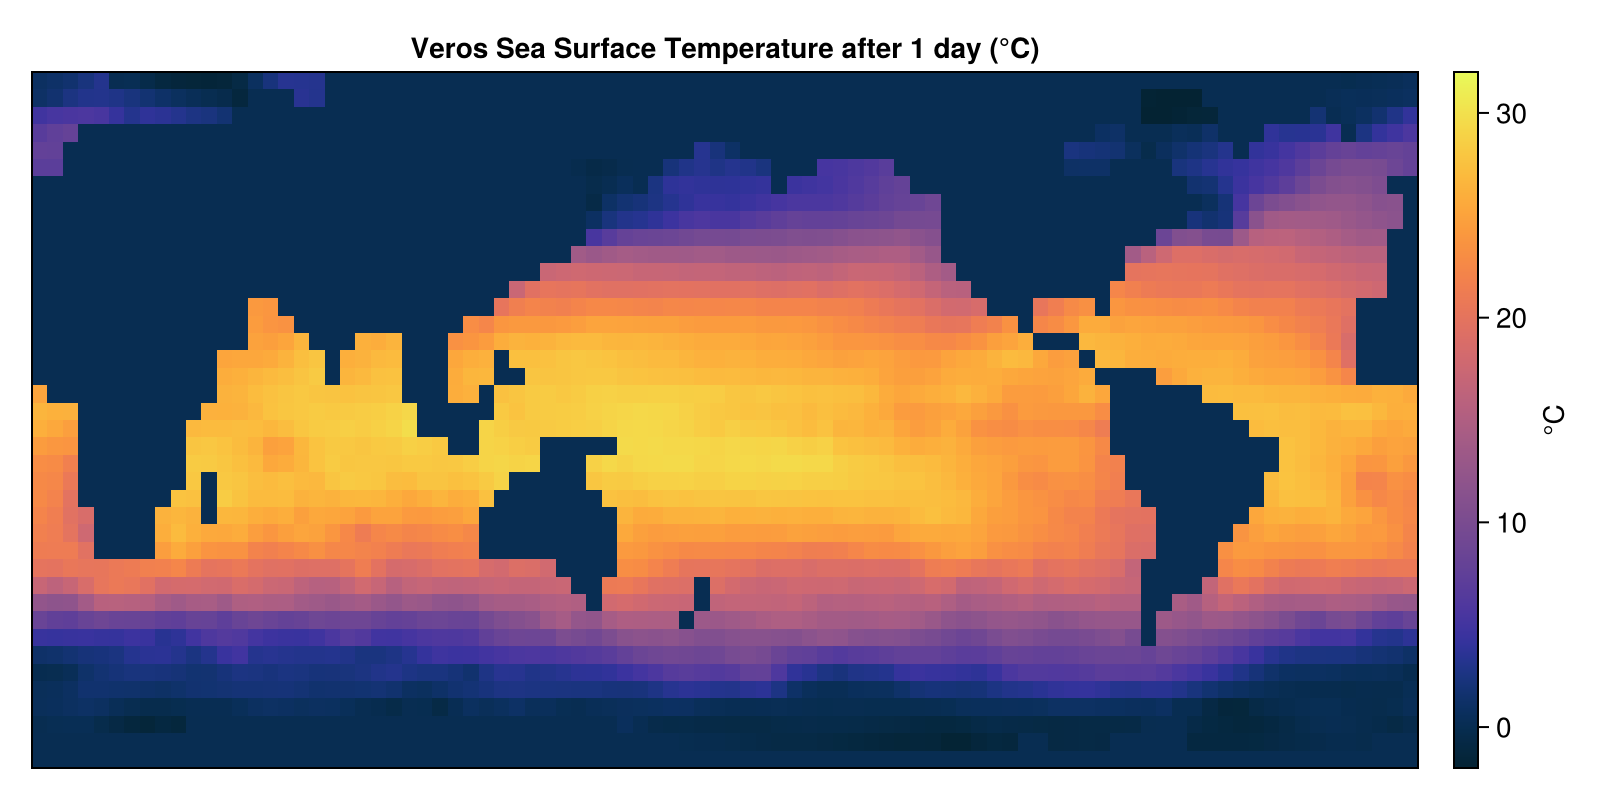

In [28]:
# Get Veros SST
veros_SST = veros_coupled.interfaces.exchanger.ocean.state.T
veros_SST_data = Array(interior(veros_SST, :, :, 1))

fig = Figure(size=(800, 400), fontsize=14)
ax = Axis(fig[1, 1], title="Veros Sea Surface Temperature after 1 day (°C)")
hidedecorations!(ax)

hm = heatmap!(ax, veros_SST_data; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label="°C")

fig

---

## Part 4: Prognostic Atmosphere (SpeedyWeather)

[SpeedyWeather.jl](https://github.com/SpeedyWeather/SpeedyWeather.jl) is a spectral atmospheric model enabling **true two-way coupling**: ocean SST affects atmospheric dynamics, and atmospheric changes feed back to ocean fluxes.


### Creating the SpeedyWeather Atmosphere

SpeedyWeather with **T31 spectral resolution** (~400km) and **3 vertical levels**—coarse resolution suitable for demonstrations.


In [29]:
using SpeedyWeather, XESMF

# Create SpeedyWeather atmosphere (coarse resolution for workshop)
spectral_grid = SpeedyWeather.SpectralGrid(; trunc=31, nlayers=3, Grid=FullClenshawGrid)
speedy_atmos = atmosphere_simulation(spectral_grid; output=true)

# Create a fresh ocean for SpeedyWeather coupling
speedy_ocean = ocean_simulation(grid; 
                                closure = (vertical_closure, horizontal_closure), 
                                tracer_advection = Centered(),
                                momentum_advection = VectorInvariant())

Oceananigans.set!(speedy_ocean.model, T=ECCOMetadatum(:temperature), 
                                      S=ECCOMetadatum(:salinity))

# Time step determined by atmosphere
Δt_speedy = convert(Float64, speedy_atmos.model.time_stepping.Δt_sec)

@info "SpeedyWeather atmosphere ready with Δt = $(prettytime(Δt_speedy))"

[ Info: Precompiling SpeedyWeather [9e226e20-d153-4fed-8a5b-493def4f21a9] (cache misses: wrong dep version loaded (6), incompatible header (10), mismatched flags (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling ModelParametersMakieExt [fe55f67a-76af-556c-8c6e-f9ee716b975d] (cache misses: wrong dep version loaded (6), incompatible header (12), mismatched flags (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling DomainSetsMakieExt [da481366-01c8-5b4d-b359-47a10c8532e7] (cache misses: wrong dep version loaded (6), incompatible header (10), mismatched flags (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling SpeedyWeatherInternalsCUDAExt [d4d8bf7a-ed3f-5a04-837d-033bc5efad69] (cache misses: wrong dep version loaded (4), incompatible header (12), mismatched flags (2)

### Coupling and Running the Two-Way System

We run for 10 days to observe the coupled evolution.


In [ ]:
# Create two-way coupled model
speedy_radiation = Radiation(ocean_emissivity=0.0, sea_ice_emissivity=0.0)
speedy_coupled = OceanSeaIceModel(speedy_ocean; atmosphere=speedy_atmos, radiation=speedy_radiation)

# Run simulation
speedy_sim = Oceananigans.Simulation(speedy_coupled; Δt=Δt_speedy, stop_time=10days)

@info "Running Ocean + SpeedyWeather (two-way coupling)..."
Oceananigans.run!(speedy_sim)

[ Info: Running Ocean + SpeedyWeather (two-way coupling)...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (18.789 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (386.968 ms).
Weather is speedy: run_0007 100%|█████████| Time: 0:01:39 (23.61 years/day)
[ Info: Simulation is stopping after running for 1.669 minutes.
[ Info: Simulation time 10 days equals or exceeds stop time 10 days.


### Visualize SpeedyWeather Results

Ocean SST and atmospheric state (temperature, surface pressure) after two-way coupled simulation. Warm SST regions correspond to warm atmospheric temperatures, confirming successful coupling.


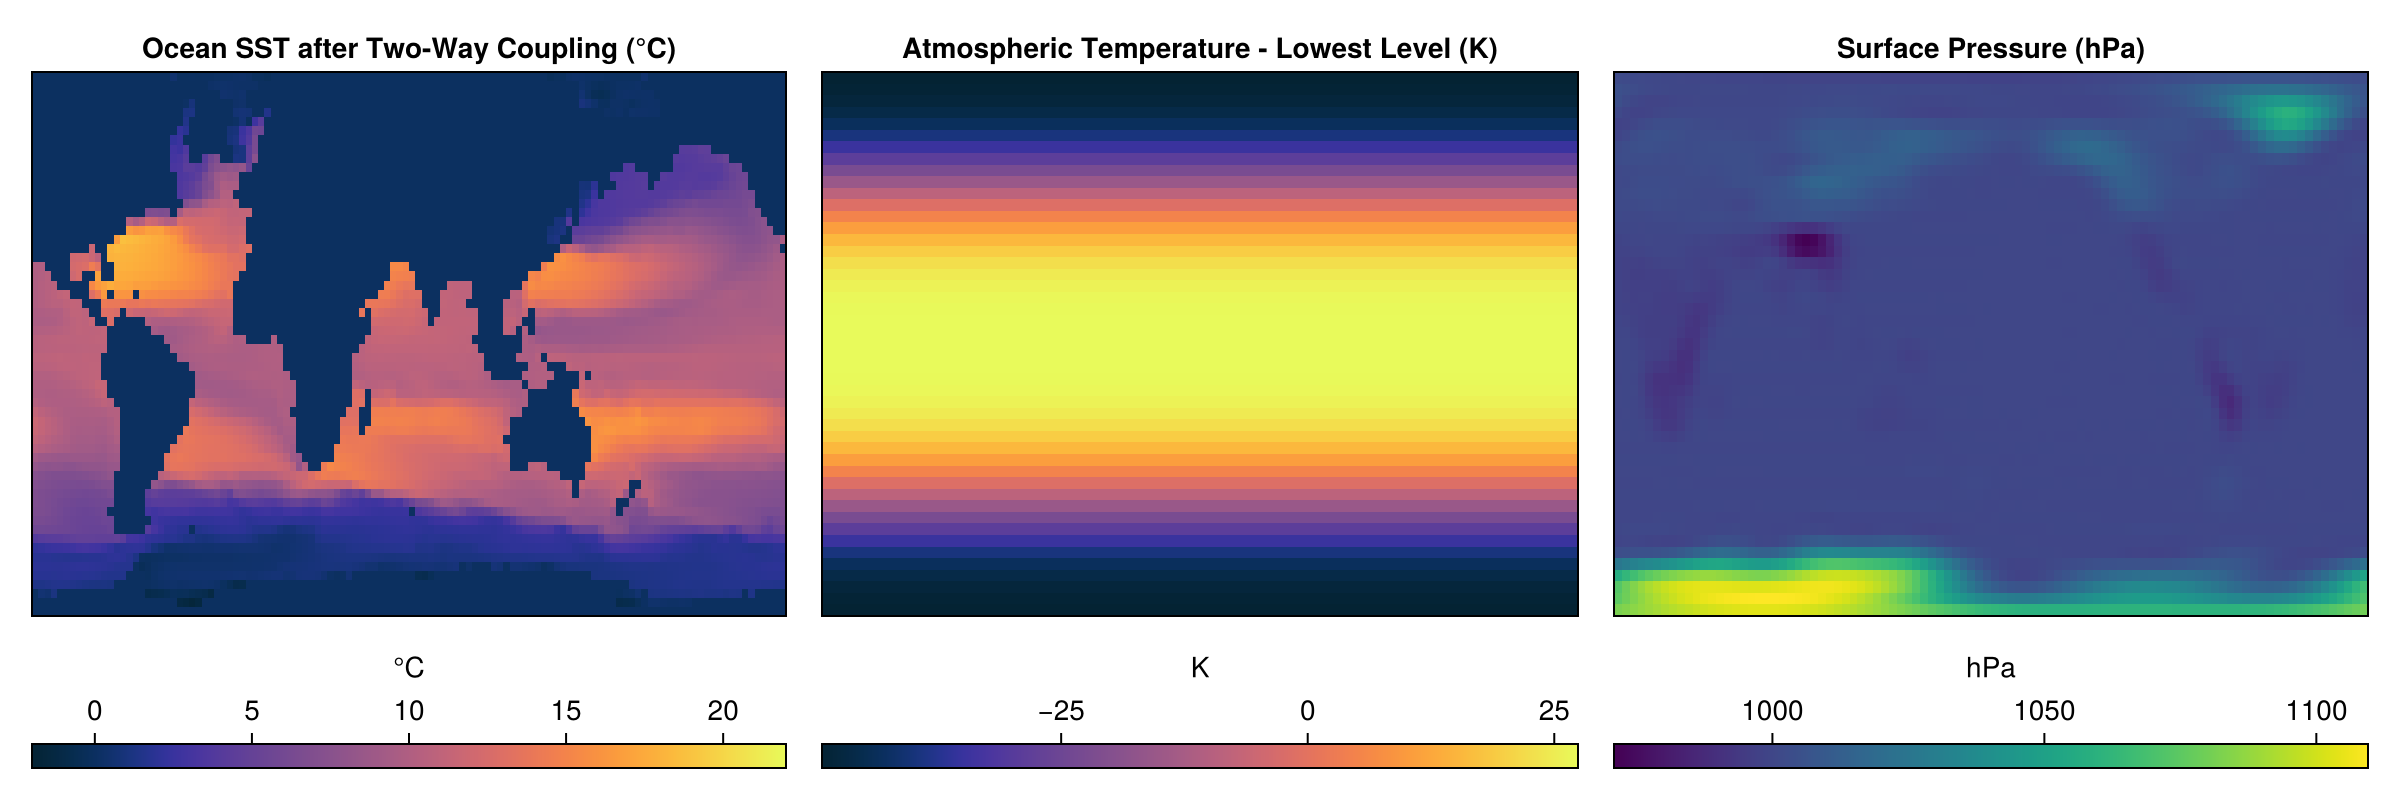

In [31]:
# Get SpeedyWeather atmosphere fields
using NCDatasets

# Find the latest SpeedyWeather output directory
run_dirs = filter(x -> startswith(x, "run_") && isdir(x), readdir("."))
if isempty(run_dirs)
    error("No SpeedyWeather output directories found. Make sure output=true was set when creating the atmosphere.")
end
latest_run = sort(run_dirs)[end]
nc_file = joinpath(latest_run, "output.nc")
SWO = Dataset(nc_file)

temp_field = reverse(SWO["temp"][:, :, end, end], dims=2)
pres_field = reverse(SWO["mslp"][:, :, end], dims=2)

# Get ocean SST
speedy_T = speedy_ocean.model.tracers.T
speedy_SST = Array(interior(speedy_T, :, :, grid.Nz))

fig = Figure(size=(1200, 400), fontsize=14)

ax1 = Axis(fig[1, 1], title="Ocean SST after Two-Way Coupling (°C)")
ax2 = Axis(fig[1, 2], title="Atmospheric Temperature - Lowest Level (K)")
ax3 = Axis(fig[1, 3], title="Surface Pressure (hPa)")

hm1 = heatmap!(ax1, speedy_SST; colormap=:thermal, colorrange=(-2, 22), nan_color=:lightgray)
hm2 = heatmap!(ax2, temp_field; colormap=:thermal)
hm3 = heatmap!(ax3, pres_field; colormap=:viridis)  # Convert Pa to hPa

Colorbar(fig[2, 1], hm1, label="°C", vertical=false)
Colorbar(fig[2, 2], hm2, label="K", vertical=false)
Colorbar(fig[2, 3], hm3, label="hPa", vertical=false)

for ax in [ax1, ax2, ax3]
    hidedecorations!(ax)
end

fig

---

## Part 5: Veros + SpeedyWeather

Ultimate flexibility: combining a **Python ocean model** (Veros) with a **Julia prognostic atmosphere** (SpeedyWeather). The coupling framework treats all components uniformly regardless of implementation language.


### Create Veros + SpeedyWeather Coupled Model

A fresh Veros ocean and SpeedyWeather atmosphere coupled together—Python and Julia models working seamlessly.


In [32]:
# Create fresh Veros ocean
VerosModule.remove_outputs(:global_4deg)
veros_speedy_ocean = VerosModule.VerosOceanSimulation("global_4deg", :GlobalFourDegreeSetup)

# Create fresh SpeedyWeather atmosphere
spectral_grid_combo = SpeedyWeather.SpectralGrid(; trunc=31, nlayers=3, Grid=FullClenshawGrid)
combo_atmos = atmosphere_simulation(spectral_grid_combo; output=true)

# Get time step from atmosphere
Δt_combo = convert(Float64, combo_atmos.model.time_stepping.Δt_sec)

@info "Created Veros ocean and SpeedyWeather atmosphere"
@info "Time step: $(prettytime(Δt_combo))"

Running model setup
 removing an annual mean heat flux imbalance of 7.860702e-02 W/m^2
Initializing streamfunction method
Computing ILU preconditioner...
 Solving for boundary contribution by island 0
 Solving for boundary contribution by island 1
 Solving for boundary contribution by island 2
 Solving for boundary contribution by island 3
 Solving for boundary contribution by island 4
 Solving for boundary contribution by island 5
 Running diagnostic "averages" every 1.0 days
 Writing output for diagnostic "averages" every 1.0 years
 Running diagnostic "energy" every 1.0 days
 Writing output for diagnostic "energy" every 1.0 years
 Running diagnostic "overturning" every 1.0 days
 Writing output for diagnostic "overturning" every 1.0 years
 Writing output for diagnostic "snapshot" every 1.0 years
Diffusion grid factor delta_iso1 = 0.013376791936035174


[ Info: Created Veros ocean and SpeedyWeather atmosphere
[ Info: Time step: 40 minutes


### Run the Simulation

Two-way cross-language coupled simulation. `PythonCall.jl` handles all Julia-Python communication transparently.


In [33]:
# Create coupled model: Veros (Python ocean) + SpeedyWeather (Julia atmosphere)
combo_radiation = Radiation(ocean_emissivity=0.0, sea_ice_emissivity=0.0)
veros_speedy_coupled = OceanSeaIceModel(veros_speedy_ocean, nothing; atmosphere=combo_atmos, radiation=combo_radiation)

# Run simulation
combo_sim = Oceananigans.Simulation(veros_speedy_coupled; Δt=Δt_combo, stop_time=10days)

wall_time = Ref(time_ns())
function combo_progress(sim)
    step_time = 1e-9 * (time_ns() - wall_time[])
    @info @sprintf("Veros+Speedy: %s | Wall: %s", prettytime(sim), prettytime(step_time))
    wall_time[] = time_ns()
end

add_callback!(combo_sim, combo_progress, TimeInterval(6hours))

@info "Running Veros (Python) + SpeedyWeather (Julia) two-way coupling..."
Oceananigans.run!(combo_sim)

[ Info: Running Veros (Python) + SpeedyWeather (Julia) two-way coupling...
[ Info: Initializing simulation...
[ Info: Veros+Speedy: 0 seconds | Wall: 3.164 seconds
[ Info:     ... simulation initialization complete (98.693 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (14.108 seconds).
Weather is speedy: run_0015   2%|▎        |  ETA: 0:00:59 (38.79 years/day)[ Info: Veros+Speedy: 6 hours | Wall: 15.461 seconds
Weather is speedy: run_0015   5%|▍        |  ETA: 0:00:55 (40.78 years/day)[ Info: Veros+Speedy: 12 hours | Wall: 1.386 seconds
Weather is speedy: run_0015   7%|▋        |  ETA: 0:00:53 (41.39 years/day)[ Info: Veros+Speedy: 18 hours | Wall: 1.387 seconds
Weather is speedy: run_0015  10%|▉        |  ETA: 0:00:51 (41.97 years/day)[ Info: Veros+Speedy: 1 day | Wall: 1.353 seconds
Weather is speedy: run_0015  12%|█▏       |  ETA: 0:00:49 (42.57 years/day)[ Info: Veros+Speedy: 1.250 days | Wall: 1.313 seconds
Weather is speedy: run_0015  15%|█

### Visualize Results

Veros SST and SpeedyWeather atmospheric state after cross-language two-way coupling.


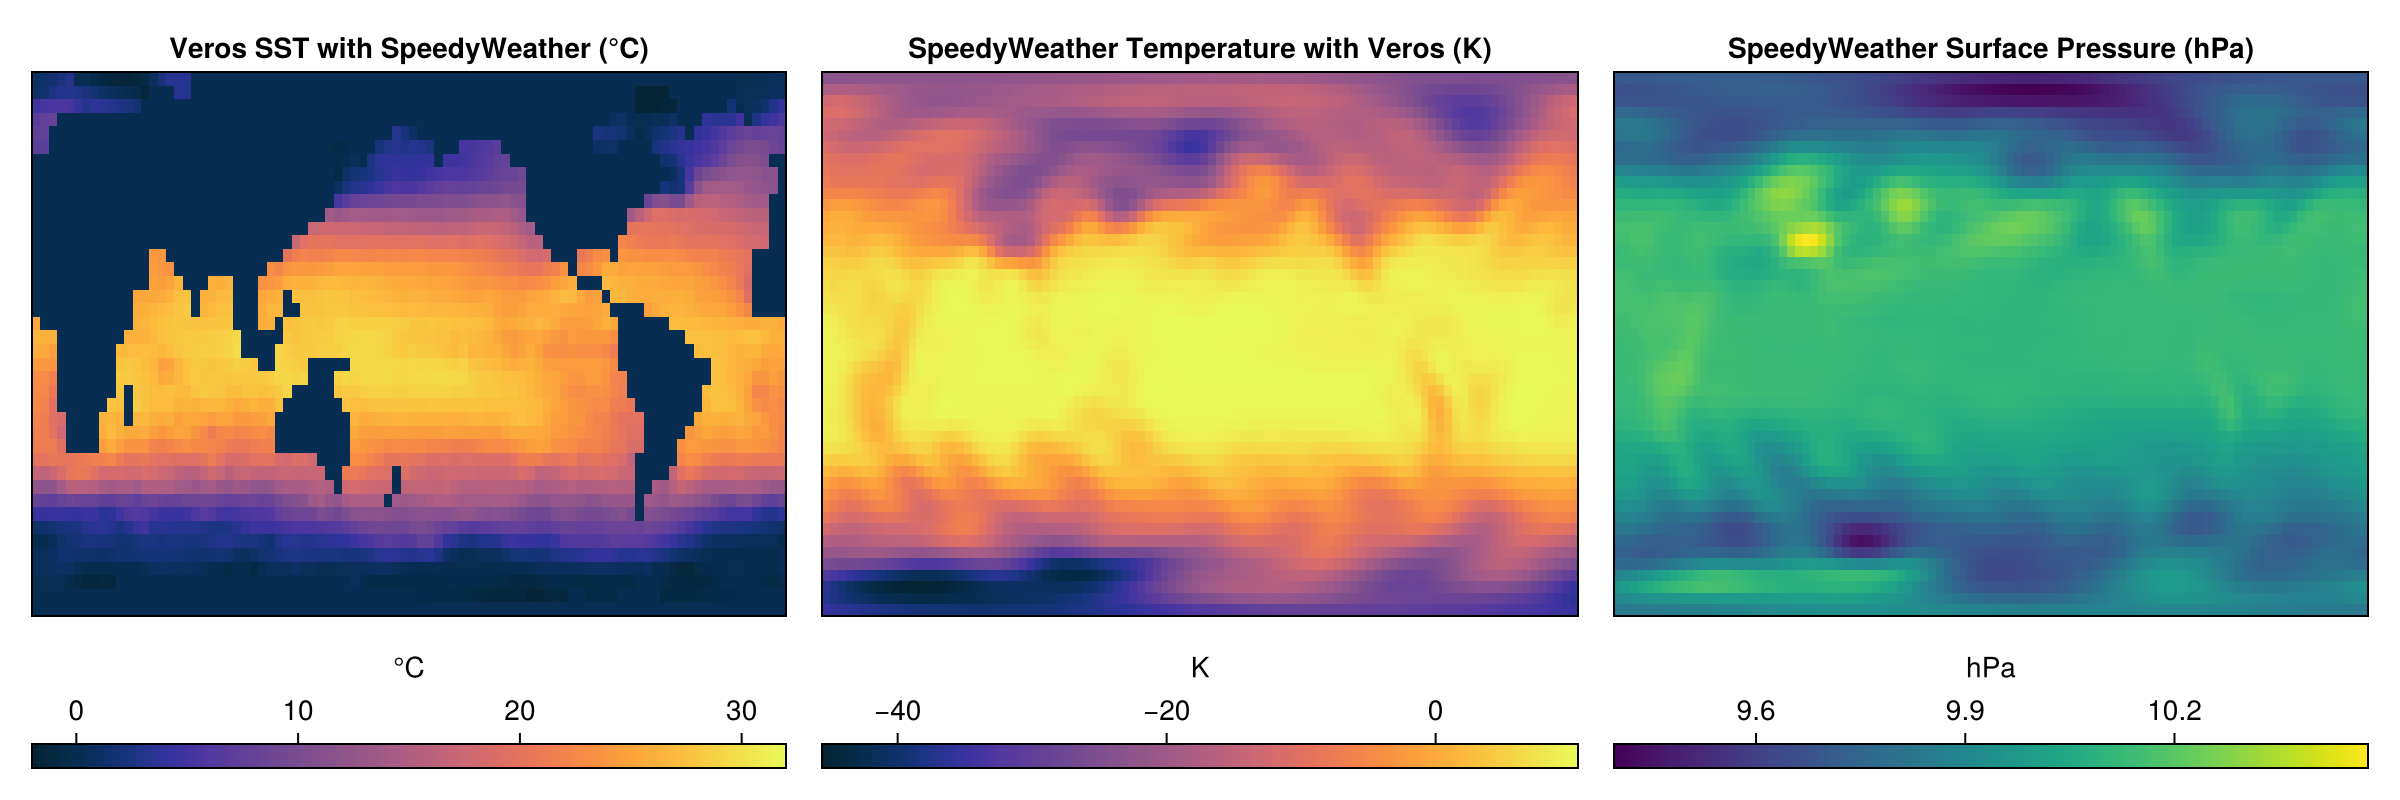

In [34]:
using NCDatasets

# Get Veros ocean SST
veros_SST = veros_coupled.interfaces.exchanger.ocean.state.T
combo_veros_SST_data = Array(interior(veros_SST, :, :, 1))

# Get SpeedyWeather atmosphere fields
SWO = Dataset("run_0008/output.nc")

combo_temp_field = reverse(SWO["temp"][:, :, end, end], dims=2)
combo_pres_field = reverse(SWO["mslp"][:, :, end], dims=2)

fig = Figure(size=(1200, 400), fontsize=14)

ax1 = Axis(fig[1, 1], title="Veros SST with SpeedyWeather (°C)")
ax2 = Axis(fig[1, 2], title="SpeedyWeather Temperature with Veros (K)")
ax3 = Axis(fig[1, 3], title="SpeedyWeather Surface Pressure (hPa)")

hm1 = heatmap!(ax1, combo_veros_SST_data; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)
hm2 = heatmap!(ax2, combo_temp_field; colormap=:thermal)
hm3 = heatmap!(ax3, combo_pres_field ./ 100; colormap=:viridis)

Colorbar(fig[2, 1], hm1, label="°C", vertical=false)
Colorbar(fig[2, 2], hm2, label="K", vertical=false)
Colorbar(fig[2, 3], hm3, label="hPa", vertical=false)

for ax in [ax1, ax2, ax3]
    hidedecorations!(ax)
end

fig


---

## Summary

**Part 2: Sea Ice** — Three-component coupling (Ocean + Sea Ice + Atmosphere) with automatic flux partitioning

**Part 3: Veros** — Cross-language coupling with Python ocean models via `PythonCall.jl`

**Part 4: SpeedyWeather** — True two-way coupling with a prognostic atmosphere

**Part 5: Veros + SpeedyWeather** — Python ocean + Julia atmosphere working together

### Key Takeaway

ClimaOcean's standardized interface enables mixing simplified and complex models, cross-language integration, and easy experimentation with different component combinations.

---

**Next**: In Notebook 2, we'll build a custom component (SlabOcean) from scratch.
